<a id="home"></a>

# GLBRC collaboration
#### Adina, Ashley, Shane, Nejc

0. [Sequencing and alignment Summaries](#seqSums)
    *  <u>Inputs:<br/></u>
        *  136 Phred-33 fastq files from samples obtained from washes of Switchgrass and Miscanthus transfered from JGI.
        *  Illumina TruSeq version 3.2 sequencing adapters. 
    *  <u>Outputs:<br/></u>
        *  [Adapter Trimming and QC (Trimmomatic) Report](#seqSums)
        *  [Host Plant Alignment Report](#pAlign)
        *  [Fungal Alignments](#fAlign)
        *  [Alignment Conclusions](#aConc)
1. Overarching analysis - changes in metagenome content over time
    *  <u>Inputs:<br/></u>
        *  Functional Gene Count table, mapped to KEGG/functions [Annotation Methodology](#annoMeth)
    *  <u>Outputs:<br/></u>
        *  [PCoA and analysis of changes over time – related time/season – use](#pcoa)
            *  [How variable are metagenomes across replicate time points?  - PERMDISP](#pDisp)
        *  [Synchrony – does the 16S change in concert with functional?](#synch)
            *  [PROTEST – Procustes superimposition, Mantel](#proTest)
                *  [Sanity check:  core metabolism changing over time?](#sCheck)
            *  Assembly of functional genes - is it stable over time, does it accumulate/convergence faster than 16S -John G infant gut - consecutive v. end point –
                *  Bray-Curtis distance of 16S t1 v t2, T1 v T3, T1 v TFinal, model of convergence for both
                *  Hierarchical clustering – clusters can inform this question (e.g. T4, 5,6 grouped with final time
        *  Core functional genes – Nejc is the point person
             *  Omit core metabolism from the normalized table to focus only on non-housekeeping functions- -
             *  Discovery/identify Occupancy 100% at a time point
                *  All genes that are in all samples – Shane is using the median
             *  Who are those core genes?
                *  Levy paper – symbiosis genes?  How to search?
                   *  Map pfams from the Levy paper to sequence level homology in KEGG?
                *  Other genes that are not mentioned in Levy but are leaf-specific (e.g., irradiation/desiccation exposure)
2.  Analysis of bins (MAGs)
  - Annotate them – who has which core functional genes (identified above)
  - How well do they overlap with our Core from the 16S paper?  %coverage – Jackson will be the point person for that
    - Match 16S (but this is problematic because probably won&#39;t assemble well)
    - Use Udeobacter paper as a guide for MAG recovery analysis as compared to 16S – use the most resolved taxonomy –
    - Basic stats on MAGs – how abundant are those taxa in the dataset and how persistent are they over time?  Where are the gaps, given the core
3.  metaT
  - Map both to metaG and to MAGs
  - Subset the core genes for this analysis?
  - Do we see the same patterns in metaG and metaT, over time?
  - Is everyone active?  What proportion of the community?  Only certain members? Can we &quot;get away&quot; with just metaG to understand who is active?

In [1]:
#HIDDEN
# import sys
# !{sys.executable} -m pip install nodejs ipywidgets==7.5.0 jupyterlab matplotlib_venn cufflinks sklearn numpy pandas scipy matplotlib plotly==4.3.0 nbinteract jupyter_contrib_nbextensions 
# # nbextension
# !{sys.executable} -m jupyter contrib nbextension install --user
# !{sys.executable} -m jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !{sys.executable} -m jupyter nbextension enable --py --sys-prefix widgetsnbextension
# !{sys.executable} -m jupyter nbextension enable --py --sys-prefix bqplot
# !{sys.executable} -m jupyter labextension install @jupyterlab/celltags

# !conda update jupyterlab && jupyter labextension update --all
# !jupyter contrib nbextension install
# !jupyter labextension install jupyter-matplotlib
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install @jupyterlab/plotly-extension
# !jupyter labextension install @jupyterlab/celltags
# !jupyter lab build
# !jupyter nbextension enable --py --sys-prefix bqplot
# !jupyter nbextension enable --py widgetsnbextension --sys-prefix
# !jupyter nbextension enable --py plotlywidget --sys-prefix

In [1]:
#Hidden

from ipywidgets import interact
def friends(name, number):
    return '{} has {} friends!'.format(name, number)
interact(friends, name='Sam', number={'One': 1, 'Five': 5, 'Ten': 10});

interactive(children=(Text(value='Sam', description='name'), Dropdown(description='number', options={'One': 1,…

In [2]:
#HIDDEN
#%matplotlib inline

from glob import glob
from IPython.display import Audio
from ipywidgets import Text, Dropdown, Output, interact
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
from pandas import DataFrame, merge, read_csv, Series, to_datetime
from pickle import dump, load
from random import randint 
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import cufflinks as cf
import numpy as np
import warnings
cf.go_offline()
# cf.set_config_file(offline=False, world_readable=True)
cf.set_config_file(offline=True, world_readable=True)

done = Audio('done.wav',autoplay=True)
warnings.simplefilter(action='ignore', category=FutureWarning)
def comma(number): return "{:,}".format(number)
def scolor(i,n,pickColor): 
    scalar = 255 - int((i/float(n))*120) 
    if pickColor: return '#%02X%02X%02X' % (128,scalar,128)
    return '#%02X%02X%02X' % (75,scalar,200)

#conda install -n base bedtools samtools khmer numpy scipy sra-tools trimmomatic jupyterlab 
#jupyter_contrib_nbextensions widgetsnbextension nodejs sra-tools r-essentials r-base r-rsqlite r-vegan bioconductor-biocinstaller 

# For metaG
metadataG = read_csv("metadata/GLBRC_MetaG_Metadata.tsv",sep='\t')
metadataG.set_index("nucleic_acid_name",inplace=True)
metadataG.drop(["source","sampling ID","sequencing_type","height_mean_cm","air_temp_c","rep","Sampling Time","reads_file_name","treatment"],axis=1,inplace=True) 
for id in metadataG.index: metadataG.loc[id,"type"] = metadataG[metadataG.index == id].plot_name[0][0:2]
metadataG['Date'] = to_datetime(metadataG.sampling_date)
metadataG=metadataG.sort_values(by=["type","Date"])
metadataG.drop(["sampling_date"],axis=1,inplace=True)
metaG_Reads = read_csv("mapping/metaG/hostRemovalFlagstats/multiqc_data/multiqc_bowtie2.txt",sep="\t")
for id in metaG_Reads.index: metaG_Reads.at[id,"Sample"] = metaG_Reads.at[id,"Sample"].replace(".stat","")
metaG_Reads.set_index("Sample",inplace=True)
metadataG = merge(metadataG,metaG_Reads,left_index=True,right_index=True)
metadataG.sort_values("Date",inplace=True)
metadataG["aligned"] = (metadataG['paired_total']-metadataG['paired_aligned_mate_none_halved'])
metadataG["percPlantAligned"]= metadataG["overall_alignment_rate"]
metadataG["Plant Reads"] = metadataG["aligned"]
metadataG["Total"] = metadataG["paired_total"]
metadataG.drop(['aligned','total_reads','paired_total','paired_aligned_none','paired_total','paired_aligned_one', 'paired_aligned_multi',
       'paired_aligned_discord_one', 'paired_aligned_mate_none',
       'paired_aligned_mate_one', 'paired_aligned_mate_multi',
       'overall_alignment_rate', 'paired_aligned_mate_multi_halved',
       'paired_aligned_mate_none_halved', 'paired_aligned_mate_one_halved'],axis=1,inplace=True)
metaG_Reads = read_csv("mapping/metaG/fungalRemovalFlagstats/multiqc_data/multiqc_bowtie2.txt",sep="\t")
for id in metaG_Reads.index: metaG_Reads.at[id,"Sample"] = metaG_Reads.at[id,"Sample"].replace(".fungal.stat","")
metaG_Reads.set_index("Sample",inplace=True)
metadataG = merge(metadataG,metaG_Reads,left_index=True,right_index=True)
metadataG.sort_values("Date",inplace=True)
metadataG["Fungal Reads"] = (metadataG['paired_total']-metadataG['paired_aligned_mate_none_halved'])
metadataG["percFungalAligned"]= metadataG["overall_alignment_rate"]
metadataG['percFungalAligned'] = Series([float("{0:.2f}%".format(val).replace("%","")) for val in metadataG['percFungalAligned']], index = metadataG.index)
metadataG['percPlantAligned']  = Series([float("{0:.2f}%".format(val).replace("%","")) for val in metadataG['percPlantAligned']], index = metadataG.index)
metadataG['Remaining'] = metadataG['paired_aligned_mate_none_halved']
metadataG['percRemaining'] = (metadataG["Remaining"]/metadataG['Total'])*100
metadataG.drop(['total_reads','paired_total','paired_aligned_none','paired_total','paired_aligned_one', 'paired_aligned_multi',
       'paired_aligned_discord_one', 'paired_aligned_mate_none',
       'paired_aligned_mate_one', 'paired_aligned_mate_multi',
       'overall_alignment_rate', 'paired_aligned_mate_multi_halved',
       'paired_aligned_mate_none_halved', 'paired_aligned_mate_one_halved'],axis=1,inplace=True)

In [ ]:
# TEST #3

In [2]:
# import qgrid
# qgrid_widget = qgrid.show_grid(metadataG,show_toolbar=True)
# qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<a id="seqSums"></a>
<h2>Sequencing and alignment Summaries</h2>
<p><b><a href="scripts/hpc_scripts/NGS_Mapping.sh">Methodology</a></b></p>
<h4>Adapter Trimming and QC (Trimmomatic) Report</h4>
<h5 style="color:blue">What is the abundance and quality of the reads in each sample?</h5>

<div class="alert alert-block alert-info">
    <p>
        <u>Step 1. Split JGI files in PE files<br/></u> 
        <div class="alert alert-block alert-warning">
              split-paired-reads.py --gzip -1 \$sample.fastq.pe1.gz -2 \$sample.fastq.pe2.gz \$jgi_combined_fastq
        </div>
        <u><br/>Step 2. Use trimmomatic to QC reads <br/></u> 
        <div class="alert alert-block alert-warning">
    trimmomatic PE -phred33 \$sample.fastq.pe1.gz \$sample.fastq.pe2.gz \$sample.fastq.pe1.gz \$sample.fastq.se1.gz \$sample.fastq.pe2.gz \$sample.fastq.se2.gz \<br> 
        &nbsp;&nbsp; ILLUMINACLIP:<b>TruSeq3-PE-2.fa</b>:2:30:10:8:TRUE \<br/>
        &nbsp;&nbsp; LEADING:3 \<br/>
        &nbsp;&nbsp; TRAILING:3 \<br/>
        &nbsp;&nbsp; SLIDINGWINDOW:4:15 \<br/>
        &nbsp;&nbsp; MINLEN:36 <br/>
        </div>
    </p>
</div>

<div class="alert alert-block alert-success">

[Outline](#home)

Skip to:   
*  Adapter Trimming and QC (Trimmomatic) Report
*  [Host Plant Alignment Report](#pAlign)
*  [Fungal Alignments](#swAlign)
*  [Alignment Conclusions](#aConc)

</div>

![alt text](images/TrimReport.png "Title")

<a id="pAlign"></a>
  
<h2>Sequencing and alignment Summaries</h2>
<h4>Host Plant Alignment Report</h4>
<h5 style="color:blue">When the reads are aligned to plant reference genomes, how many of the reads are plant-aligned reads?</h5>


<div class="alert alert-block alert-info">
    <p>
        <u>Step 1. Align reads to respective host reference assembly<br/></u> 
        <div class="alert alert-block alert-warning">
            if [[ \$sample == *"G5"* ]]; then <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; SAMFILE=\$sample.SWGRASS.sam <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; BAMFILE=\$sample.SWGRASS.bam <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; bowtie2 --threads \$THREADS -x \$SWITCHGRASS <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -1 \$sample.fastq.pe1.gz -2 \$sample.fastq.pe2.gz <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -U \$sample.fastq.se12.gz -S \$sample.SWGRASS.sam 2>\$sample.stat  <br/>
            else <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; SAMFILE=\$sample.MISCANTS.sam <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; BAMFILE=\$sample.MISCANTS.bam <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; bowtie2 --threads \$THREADS -x \$MISCANTHUS  <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -1 \$sample.fastq.pe1.gz -2 \$sample.fastq.pe2.gz <br/>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -U \$sample.fastq.se12.gz -S \$sample.MISCANTS.sam 2>\$sample.stat  <br/>
            fi
        </div>
    </p>
</div>

<div class="alert alert-block alert-success">

[Outline](#home)

Skip to:   
*  [Adapter Trimming and QC (Trimmomatic) Report](#seqSums)
*  Host Plant Alignment Report
*  [Fungal Alignments](#fAlign)
*  [Alignment Conclusions](#aConc)
    
</div>

In [ ]:
!jupyter trust GLBRC_Report2.ipynb

In [19]:
from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected=True)

In [14]:
import plotly.io as pio
import plotly.graph_objects as go
print(pio.renderers)
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="Testing dif options for rendeerers; jupLab"
)
fig.show(renderer="jupyterlab")

Renderers configuration
-----------------------
    Default renderer: 'jupyterlab'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

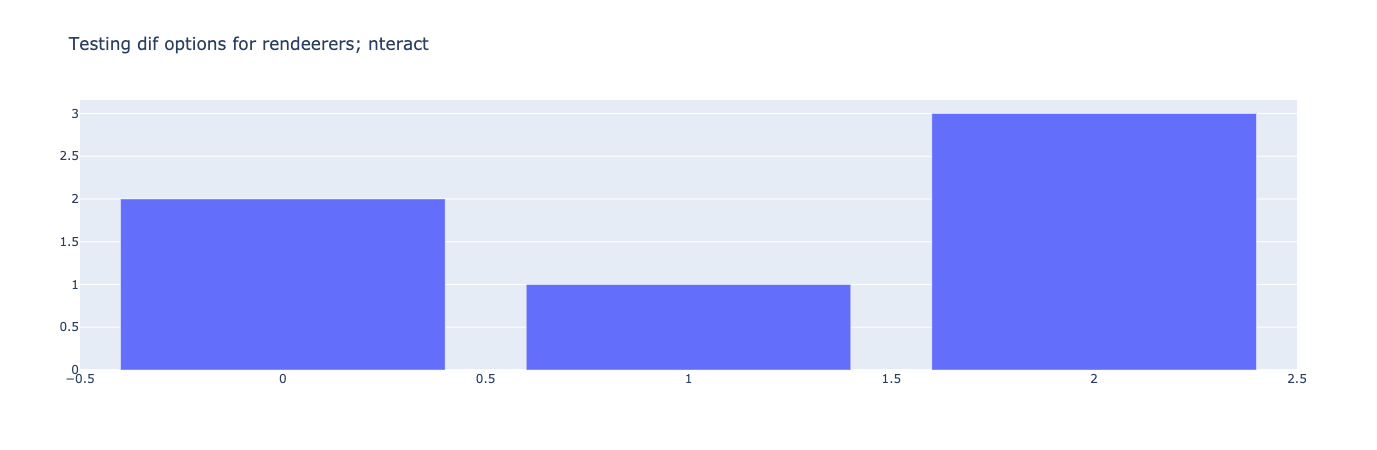

In [23]:
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="Testing dif options for rendeerers; nteract"
)
fig.offline.show(renderer="nteract")

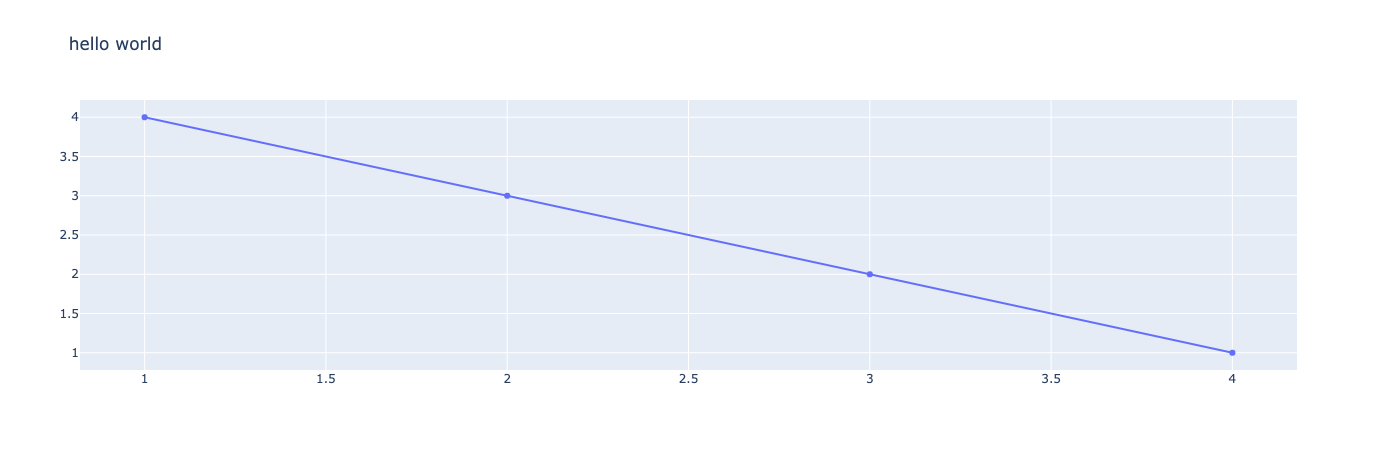

In [31]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=[1, 2, 3, 4], y=[4, 3, 2, 1])],
    "layout": go.Layout(title="hello world")
})

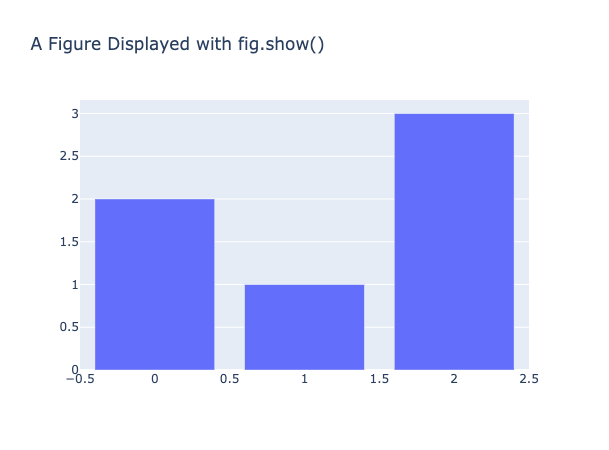

In [15]:
fig = go.Figure(
    data=[go.Bar(y=[2, 1, 3])],
    layout_title_text="Testing dif options for rendeerers; plotly_mimetype"
)
fig.show(renderer="plotly_mimetype",auto_open=True)

In [16]:
# import numpy as np
# import chart_studio.plotly as py

# import plotly.graph_objs as go

# # py.offline.init_notebook_mode()
# a = np.linspace(start=0, stop=36, num=36)
# np.random.seed(25)
# b = np.random.uniform(low=0.0, high=1.0, size=36)

# trace = go.Scatter(x=a, y=b)
# data = [trace]
# py.iplot(data, filename = 'basic-file')


In [ ]:
# done I

In [4]:
#HIDDEN
%matplotlib widget

@interact
def graph(Host_Plant=["Switchgrass & Miscanthus","Switchgrass","Miscanthus"],By=["Percentage","Count"]):
    G5Data = metadataG[metadataG['type'] == 'G5']
    G6Data = metadataG[metadataG['type'] == 'G6']
    ax = None
    if By == "Percentage":
        if (Host_Plant == "Switchgrass & Miscanthus"):
            ax = metadataG.groupby(['Date','plot_name']).sum()['percPlantAligned'].unstack().iplot(title="% Reads Aligning to Respective Plant Host Assembly G5=Switchgrass G6=Miscanthus");
#             print(dir(ax))
#             f = ax.get_figure()
#             f.savefig("images/CombinedPlantLineGraph.png")
        elif Host_Plant == "Switchgrass":
            ax = G5Data.groupby(['Date','plot_name']).sum()['percPlantAligned'].unstack().iplot(title="% Reads Aligning to Switchgrass Assembly",fontsize=12);
        else: # "Miscanthus":
            ax = G6Data.groupby(['Date','plot_name']).sum()['percPlantAligned'].unstack().iplot(title="% Reads Aligning to Micanthus Assembly",fontsize=12);
        ylim = 100
        ylab = "% Reads"
    else:
        colors = ["#74C476", "#f26d07","#794955"]
        if (Host_Plant == "Switchgrass & Miscanthus"):
            ax = metadataG.loc[:,['Plant Reads','Fungal Reads', 'Remaining']].iplot(kind='bar', barmode = 'stack', color=colors, title="Reads Counts By Source")
        elif Host_Plant == "Switchgrass":
            ax = G5Data.loc[:,['Plant Reads','Fungal Reads', 'Remaining']].iplot(kind='bar', barmode = 'stack', color=colors, title="Switchgrass Reads Counts")
        else:
            ax = G5Data.loc[:,['Plant Reads','Fungal Reads', 'Remaining']].iplot(kind='bar', barmode = 'stack', color=colors, title="Miscanthus Reads Counts By Source")
    
    return ax

interactive(children=(Dropdown(description='Host_Plant', options=('Switchgrass & Miscanthus', 'Switchgrass', '…

![alt text](images/CombinedPlantLineGraph.png "Title")

<a id="fAlign"></a>
  
<h2>Sequencing and alignment Summaries</h2>
<h4>Fungal Alignment Report</h4>
<h5 style="color:blue">What reads are fungal reads?</h5>

<div class="alert alert-block alert-info">
    <p>
        <u><br/>Step 1. Extract reads that don't align the plant assembly <br/></u> 
        <div class="alert alert-block alert-warning">
            # A. Convert sam > bam <br/>
            samtools view -bS \$SAMFILE > \$BAMFILE <br/><br/>
            # B. Extract all unmapped reads (-f 4) that don't have a mate mapped (-F 256 i.e. both unmapped) <br/>
            samtools view -b -f 4 -F 256 \$BAMFILE > \$sample.unmapped.bam <br/><br/>
            # C. Sort the reads <br/>
            samtools sort -n \$sample.unmapped.bam -o \$sample.unmapped_sorted.bam <br/><br/>
            # D. Split the unmapped reads in R1 & R2 (back into paired end) <br/>
            bedtools bamtofastq -i \$sample.unmapped_sorted.bam -fq \$sample.R1.fastq -fq2 \$sample.R2.fastq
        </div>
        <u><br/>Step 2. Align the reads to the combined fungal assemblies <br/></u> 
        <div class="alert alert-block alert-warning">
            bowtie2 -x \$FUNGAL -1 \$sample.R1.fastq -2 \$sample.R2.fastq -S \$sample.fungal.sam 2>\$sample.fungal.stat
        </div>
    </p>
</div>
<div class="alert alert-block alert-success">

[Outline](#home)

Skip to:   
*  [Adapter Trimming and QC (Trimmomatic) Report](#seqSums)
*  [Host Plant Alignment Report](#pAlign)
*  Fungal Alignments
*  [Alignment Conclusions](#aConc)
    
</div>

In [4]:
#HIDDEN

@interact
def fungalAlign(Samples=["Switchgrass", "Miscanthus", "Switchgrass & Miscanthus"]):
    if Samples == "Switchgrass":
        G5Data = metadataG[metadataG['type'] == 'G5']
        return G5Data.groupby(['Date','plot_name']).sum()['percFungalAligned'].unstack().iplot(yTitle="Percentage of Reads",title="Switchgrass Samples Perctages of Reads Aligning to Combined Fungal Assemblies");
    elif Samples == "Miscanthus":
        G6Data = metadataG[metadataG['type'] == 'G6']
        return G6Data.groupby(['Date','plot_name']).sum()['percFungalAligned'].unstack().iplot(yTitle="Percentage of Reads",title="Miscanthus Samples Perctages of Reads Aligning to Combined Fungal Assemblies");
    else:
        return metadataG.groupby(['Date','plot_name']).sum()['percFungalAligned'].unstack().iplot(yTitle="Percentage of Reads",title="All Samples Perctages of Reads Aligning to Combined Fungal Assemblies");

interactive(children=(Dropdown(description='Samples', options=('Switchgrass', 'Miscanthus', 'Switchgrass & Mis…

![text](images/SwitchgrassMicanFungal.png)

<a id="aConc"></a>
  
<h2 style="text-decoration: underline;">Sequencing and alignment Summaries</h2>
<h4>Sequencing Observations</h4>
<h5 style="color:blue">What patterns are there over the season?</h5>

<ol>
    <li>The percentage of plant reads sequenced is high thoughout the season and tapers off towards the end of the season. This may be do to senescence of plant cells.</li>
    <li>Alignment to the 6 selected fungal assemblies is low, but picks up during the warmer months. Overall, reads aligning to the combined fungal assembly were &lt;10% of the non-plant reads.</li>
</ol>

<div class="alert alert-block alert-success">

[Outline](#home)

Skip to:   
*  [PCoA](#readbd)
*  [Host Plant Alignment Report](#pAlign)
*  [Fungal Alignments](#fAlign)
*  Alignment Conclusions
    
</div>

<a id="accum"></a>
<h2 style="text-decoration: underline;">Overarching analysis - changes in metagenome content over time</h2>

<div class="alert alert-block alert-success">

[Outline](#home)

Skip to: 
*  Functional annotation accumulation over time
*  [Is time a factor that affects the functional richness of phylosphere communities (Alpha Diversity)?](#alphaD)
*  [Do we see changes over time in functional richness?](#funcRich)
*  [Is there a difference between treatment (Fertilized vs. Unfertilized)?](#treatComp)
*  [Is there a difference between host plant?](#plantDif)    
*  [PCoA of functional counts](#pcoa)
*  [Is there similarity between the WGS communities and the 16S data?](#comp16S)
*  [How variable are metagenomes across replicate time points?](#permdisp)

    
</div>


<h4>COG accumulation over time</h4>

![pcoa](ShadeLabCode/R/Figures/Figure1B_COG_GenesAccumulation2.png)

<a id="alphaD"></a>
<h4 style="color:blue">Is time a factor that affects the functional richness of phylosphere communities (Alpha Diversity)?</h4>


<table>
    <tr>
        <td>
            <table style="border: 1px solid black;">
                <tr style="border: 1px solid black;">
                    <th colspan="3">Switchgrass Pearson's product-moment correlation</th>
                </tr>
                <tr style="border: 1px solid black;">
                    <td style="text-align: right">Data:</td>
                    <td colspan="2">Time and Richness</td>
                </tr>    
                <tr style="border: 1px solid black;">
                    <td style="border: 1px solid black;">t = 10.223</td>
                    <td style="border: 1px solid black;">df = 62</td>
                    <td style="border: 1px solid black;">p-value = 6.316e-15</td>
                </tr>    
                <tr>
                    <td colspan="3" style="text-align: center">sample estimates: cor 0.7922484 </td>
                </tr>    
            </table>
        </td>
        <td>
            <table style="border: 1px solid black;">
                <tr style="border: 1px solid black;">
                    <th colspan="3">Switchgrass Pearson's product-moment correlation</th>
                </tr>
                <tr style="border: 1px solid black;">
                    <td style="text-align: right">Data:</td>
                    <td colspan="2">Time and Shannon</td>
                </tr>    
                <tr style="border: 1px solid black;">
                    <td style="border: 1px solid black;">t = 7.1534</td>
                    <td style="border: 1px solid black;">df = 62</td>
                    <td style="border: 1px solid black;">p-value = 1.166e-09</td>
                </tr>    
                <tr>
                    <td colspan="3" style="text-align: center">sample estimates: cor 0.6724267 </td>
                </tr>    
            </table>
        </td>
        <td>
            <table style="border: 1px solid black;">
                <tr style="border: 1px solid black;">
                    <th colspan="3">Switchgrass Pearson's product-moment correlation</th>
                </tr>
                <tr style="border: 1px solid black;">
                    <td style="text-align: right">Data:</td>
                    <td colspan="2">Time and Pielou</td>
                </tr>    
                <tr style="border: 1px solid black;">
                    <td style="border: 1px solid black;">t = 5.6951</td>
                    <td style="border: 1px solid black;">df = 62</td>
                    <td style="border: 1px solid black;">p-value = 3.622e-07</td>
                </tr>    
                <tr>
                    <td colspan="3" style="text-align: center">sample estimates: cor 0.586056 </td>
                </tr>    
            </table>
        </td>
    </tr>
    <tr>
        <td>
            <table style="border: 1px solid black;">
                <tr style="border: 1px solid black;">
                    <th colspan="3">Miscanthus Pearson's product-moment correlation</th>
                </tr>
                <tr style="border: 1px solid black;">
                    <td style="text-align: right">Data:</td>
                    <td colspan="2">Time and Richness</td>
                </tr>    
                <tr style="border: 1px solid black;">
                    <td style="border: 1px solid black;">t = 8.5659</td>
                    <td style="border: 1px solid black;">df = 70</td>
                    <td style="border: 1px solid black;">p-value = 1.658e-12</td>
                </tr>    
                <tr>
                    <td colspan="3" style="text-align: center">sample estimates: cor 0.7153784 </td>
                </tr>    
            </table>
        </td>
        <td>
            <table style="border: 1px solid black;">
                <tr style="border: 1px solid black;">
                    <th colspan="3">Miscanthus Pearson's product-moment correlation</th>
                </tr>
                <tr style="border: 1px solid black;">
                    <td style="text-align: right">Data:</td>
                    <td colspan="2">Time and Shannon</td>
                </tr>    
                <tr style="border: 1px solid black;">
                    <td style="border: 1px solid black;">t = 6.1267</td>
                    <td style="border: 1px solid black;">df = 70</td>
                    <td style="border: 1px solid black;">p-value = 4.675e-08</td>
                </tr>    
                <tr>
                    <td colspan="3" style="text-align: center">sample estimates: cor 0.5908107 </td>
                </tr>    
            </table>
        </td>
        <td>
            <table style="border: 1px solid black;">
                <tr style="border: 1px solid black;">
                    <th colspan="3">Miscanthus Pearson's product-moment correlation</th>
                </tr>
                <tr style="border: 1px solid black;">
                    <td style="text-align: right">Data:</td>
                    <td colspan="2">Time and Pielou</td>
                </tr>    
                <tr style="border: 1px solid black;">
                    <td style="border: 1px solid black;">t = 7.1602</td>
                    <td style="border: 1px solid black;">df = 70</td>
                    <td style="border: 1px solid black;">p-value = 6.369e-10</td>
                </tr>    
                <tr>
                    <td colspan="3" style="text-align: center">sample estimates: cor 0.6502079 </td>
                </tr>    
            </table>
        </td>
    </tr>
</table>

<a id="funcRich"></a>
<h4 style="color:blue">Do we see changes over time in functional richness?</h4>

Call:
adonis(formula = dist.otu ~ map_16S\$time_numeric) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                      Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
map_16S$time_numeric   1    1.9356 1.93562  47.814 0.26298  0.001 ***
Residuals            134    5.4246 0.04048         0.73702           
Total                135    7.3603                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<a id="treatComp"></a>
<h4 style="color:blue">Is there a difference between treatment (Fertilized vs. Unfertilized)?</h4>

Call:
adonis(formula = dist.otu ~ map_16S\$treatment) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

                   Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)
map_16S$treatment   1    0.0289 0.028930 0.52878 0.00393  0.755
Residuals         134    7.3313 0.054711         0.99607       
Total             135    7.3603                  1.00000  

<a id="plantDif"></a>
<h4 style="color:blue">Is there a difference between host plant?</h4>

Call:
adonis(formula = dist.otu ~ map_16S\$plant) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

               Df SumsOfSqs  MeanSqs F.Model      R2 Pr(>F)  
map_16S$plant   1    0.1617 0.161704  3.0101 0.02197  0.027 *
Residuals     134    7.1986 0.053721         0.97803         
Total         135    7.3603                  1.00000         
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

<a id="pcoa"></a>
<h4 style="color:blue">PCoA</h4>

In [4]:
#HIDDEN
from IPython.display import Image

@interact
def dataSet(Normalized_By=["Total Reads","Non Plant Reads"]):
    if "Total Reads" == Normalized_By:
        return Image(filename='ShadeLabCode/R/Figures/Figure2B_PhyllospherePCoAGenes.png') 
    else:
        return Image(filename='ShadeLabCode/R/Figures/Figure2B_PhyllospherePCoAGenes2.png') 

interactive(children=(Dropdown(description='Normalized_By', options=('Total Reads', 'Non Plant Reads'), value=…

![text](ShadeLabCode/R/Figures/Figure2B_PhyllospherePCoAGenes2.png)

<a id="comp16S"></a>
<h4 style="color:blue">Is there similarity between the WGS communities and the 16S data (mantel/procrustes)?</h4>

Mantel statistic based on Pearson's product-moment correlation 

Call:
mantel(xdis = genes.dist, ydis = otu.dist) 

Mantel statistic r: 0.6526 
      Significance: 0.001 

Upper quantiles of permutations (null model):
   90%    95%  97.5%    99% 
0.0833 0.1194 0.1458 0.1849 
Permutation: free
Number of permutations: 999

Call:
protest(X = genes.pcoa, Y = otu.pcoa) 

Procrustes Sum of Squares (m12 squared):        0.5402 
Correlation in a symmetric Procrustes rotation: 0.6781 
Significance:  0.001 

Permutation: free
Number of permutations: 999

[Home](#home)

<h1><a id="annoMeth">Annotation Methodology</a></h1>

  - Decide how to normalize the data
    - Coverage is good, community is simple
      - [x] Option 1:  Relative abundances
      - Option 2:  counts per single copy gene/cell
        - To decide:  use MicrobeCensus to ask whether there are changes in average genome size over time – Jackson will work together with Shane to run it
          - If yes, use option 2
          - If no, use option 1
  - [x] Mapping to KEGG/Functions – Shane will write a script to do that

<li>The overlap between which contigs have both a prokaryotic and a eukaryotic annotation suggest either shared gene similarity or eukarotic contamination.</li>

<h2 id="anno">Assembly and MAGs</h2>
<p>The fittered reads (All-(plant+fungal)) were used to generate a metagenomic assembly. The assembly was then annotated with a set of prokaryotic peptides and a set of eukaryotic peptides. The diagram below shows numbers for contigs that had only prokayotic, both, and only eukarotic respectively.</p>

In [ ]:
#HIDDEN
EukaryoticAnnotations, ProkaryoticAnnotations = set(), set()
for line in open("annotations/EukAnnotatedContigIDs2.txt"):  EukaryoticAnnotations.add(line.strip())
for line in open("annotations/ProkAnnotatedContigIDs.txt"): ProkaryoticAnnotations.add(line.strip())
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
# First way to call the 2 group Venn diagram:
venn2(subsets = (len(ProkaryoticAnnotations.difference(EukaryoticAnnotations)), len(ProkaryoticAnnotations.intersection(EukaryoticAnnotations)), len(EukaryoticAnnotations.difference(ProkaryoticAnnotations))), set_labels = ('Prokaryotic Contigs','Eukaryotic Contigs'))
plt.title('Contigs with an Annotation')
plt.show()

In [18]:
#HIDDEN
import nbinteract as nbi

nbi.publish("skdooley/GLBRC/master", "GLBRC_Report2.ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... 

Converting notebook...



Successfully converted!

<a href="GLBRC_Report2.html" target="_blank" download>Click to download your webpage.</a>

To host your webpage, see the documentation:
<a href="https://www.nbinteract.com/tutorial/tutorial_publishing.html"
        target="_blank">
    https://www.nbinteract.com/tutorial/tutorial_publishing.html
</a>


<h2 id="magsReport">MAGs Report</h2>

<!-- ### Remove Human Disease Pathway related rows

# allSampleCounts = allSampleCounts[allSampleCounts.Level1 != "Human Diseases"]
# allSampleCounts.shape

### Normalize by total reads and log transform

# from numpy import log, nan
# for sample in metadataG.index:
#     allSampleCounts[sample]= -log(allSampleCounts[sample].replace(0, nan)/metadataG.loc[sample,"total_reads"])
# for sample in metadataG.index: allSampleCounts[sample]= allSampleCounts[sample].replace(nan, 0)
# allSampleCounts.head()

# for level in ["Level1","Level2","Level3"]:
#     outfile = "annotations/%s_CountTable_logged2.tsv" % (level)
#     levelDF = allSampleCounts.groupby([level]).sum()
#     levelDF.to_csv(outfile,sep='\t')

# colors = ["#74C476", "#f26d07","#794955"]
# G5_metadata = metadataG[metadataG.type == "G5"]
# G6_metadata = metadataG[metadataG.type == "G6"]

# ax = G5_metadata.loc[:,['Plant Reads','Fungal Reads', 'Remaining']].plot.bar(stacked=True, color=colors, figsize=(14,7))
# ax.set_ylabel("Read Count",fontsize=12)
# ax.set_ylim(0,16000000)

# fig = ax.get_figure()
# fig.savefig('images/MiscanthusBarCombined.png')
# ax = G6_metadata.loc[:,['Plant Reads','Fungal Reads', 'Remaining']].plot.bar(stacked=True, color=colors, figsize=(14,7))
# ax.set_ylabel("Read Count (Millions)",fontsize=12)
# fig = ax.get_figure()
# fig.savefig('images/SwitchgrassBarCombined.png')

# metaG_Reads = read_csv("mapping/metaG/fullAssembly/multiqc_data/multiqc_bowtie2.txt",sep="\t")
# for id in metaG_Reads.index: metaG_Reads.at[id,"Sample"] = metaG_Reads.at[id,"Sample"].replace(".fungal.stat","")
# metaG_Reads.set_index("Sample",inplace=True)

# metadataG = merge(metadataG,metaG_Reads,left_index=True,right_index=True)
# metadataG.sort_values("Date",inplace=True)

# metadataG = metadataG[metadataG['type']=="G5"] # SWITCHGRASS Only

# metadataG["total_reads"].plot(kind='bar',ax=plt.subplot(121),figsize=(30,10),title="SG MetaG after host removal",color='orange')
# metadataT["total_reads"].plot(kind='bar',ax=plt.subplot(122),figsize=(30,10),title="SG MetaT after host removal")
# plt.show()

#HIDDEN

dataStr = """G5R2_MAIN_09MAY2016_LD1,G5R2_MAIN,G5,2016-05-09,43.02,2444885.5,5682372,230.5,0.01,3101297.5,54.57751622033897
G5R4_NF_09MAY2016_LD1,G5R4_NF,G5,2016-05-09,79.73,4575140.5,5737475,245.0,0.03,938323.0,16.354284768125353
G5R1_NF_09MAY2016_LD1,G5R1_NF,G5,2016-05-09,37.16,2034146.5,5473795,487.0,0.01,3333201.0,60.89378575558639
G5R2_NF_09MAY2016_LD1,G5R2_NF,G5,2016-05-09,61.07,4093313.5,6700488,383.5,0.02,2401160.5,35.83560630210815
G5R4_MAIN_09MAY2016_LD1,G5R4_MAIN,G5,2016-05-09,85.16,4535606.0,5324879,283.5,0.05,569866.5,10.701961490580349
G5R1_MAIN_09MAY2016_LD1,G5R1_MAIN,G5,2016-05-09,73.46,5016843.5,6828883,240.0,0.02,1572579.0,23.028348852952966
G5R3_NF_09MAY2016_LD1,G5R3_NF,G5,2016-05-09,80.7,5001844.0,6196018,199.5,0.02,949029.5,15.316764735028206
G6R1_MAIN_09MAY2016_LD1,G6R1_MAIN,G6,2016-05-09,85.88,5766456.0,6713739,39.0,0.01,559512.0,8.33383603384046
G5R3_MAIN_09MAY2016_LD1,G5R3_MAIN,G5,2016-05-09,84.41,4590265.0,5436507,272.5,0.04,625518.5,11.505889719262754
G6R3_MAIN_09MAY2016_LD1,G6R3_MAIN,G6,2016-05-09,86.34,6169902.0,7145090,63.0,0.01,564880.0,7.905848631717725
G6R1_NF_09MAY2016_LD1,G6R1_NF,G6,2016-05-09,86.57,6516872.5,7527497,52.5,0.01,571074.5,7.586512488812683
G6R2_MAIN_09MAY2016_LD1,G6R2_MAIN,G6,2016-05-09,86.06,5759999.0,6692593,115.5,0.02,549879.5,8.216239953632321
G6R4_NF_09MAY2016_LD1,G6R4_NF,G6,2016-05-09,86.98,5748471.0,6607949,88.5,0.02,480675.5,7.274201117472305
G6R2_NF_09MAY2016_LD1,G6R2_NF,G6,2016-05-09,86.22,11483052.5,13316083,228.5,0.02,1075775.5,8.078768358533061
G6R4_MAIN_09MAY2016_LD1,G6R4_MAIN,G6,2016-05-09,86.36,10680511.5,12361687,570.5,0.06,985639.5,7.973341340870384
G6R3_NF_09MAY2016_LD1,G6R3_NF,G6,2016-05-09,86.58,5920682.5,6837832,62.5,0.01,523727.5,7.65926246798693
G6R1_MAIN_31MAY2016_LD1,G6R1_MAIN,G6,2016-05-31,86.0,4589765.0,5336461,204.0,0.05,447497.0,8.385651089739062
G5R1_MAIN_31MAY2016_LD1,G5R1_MAIN,G5,2016-05-31,87.81,5542677.0,6310890,394.5,0.08,491297.5,7.784916232100385
G5R4_MAIN_31MAY2016_LD1,G5R4_MAIN,G5,2016-05-31,88.47,5921339.0,6691560,427.5,0.09,475789.5,7.1102926671807465
G5R4_NF_31MAY2016_LD1,G5R4_NF,G5,2016-05-31,87.97,5218316.5,5931777,626.5,0.14,456660.5,7.698544635106816
G5R2_MAIN_31MAY2016_LD1,G5R2_MAIN,G5,2016-05-31,88.29,10553216.5,11950005,619.0,0.07,879644.0,7.36103457697298
G5R1_NF_31MAY2016_LD1,G5R1_NF,G5,2016-05-31,87.65,6821004.0,7776723,938.0,0.16,601802.0,7.738503737371126
G5R2_NF_31MAY2016_LD1,G5R2_NF,G5,2016-05-31,88.12,8249743.5,9358299,439.0,0.06,674956.0,7.212379087267889
G5R3_NF_31MAY2016_LD1,G5R3_NF,G5,2016-05-31,87.5,5036978.0,5755740,714.0,0.15,474196.0,8.238662622008638
G6R2_NF_31MAY2016_LD1,G6R2_NF,G6,2016-05-31,86.3,6707432.0,7771064,210.0,0.03,628542.0,8.088236051073572
G6R3_MAIN_31MAY2016_LD1,G6R3_MAIN,G6,2016-05-31,85.16,5393305.5,6331750,557.0,0.09,589557.0,9.311122517471473
G6R1_NF_31MAY2016_LD1,G6R1_NF,G6,2016-05-31,85.65,5390104.5,6292542,689.5,0.13,545324.5,8.66620357877627
G6R4_MAIN_31MAY2016_LD1,G6R4_MAIN,G6,2016-05-31,84.24,5567014.5,6607123,572.0,0.08,676111.0,10.233062105851518
G6R2_MAIN_31MAY2016_LD1,G6R2_MAIN,G6,2016-05-31,85.91,5781888.5,6729977,440.5,0.07,603103.5,8.961449645370259
G6R4_NF_31MAY2016_LD1,G6R4_NF,G6,2016-05-31,85.77,6503491.5,7581116,545.5,0.08,699856.5,9.231576195378095
G5R3_MAIN_31MAY2016_LD1,G5R3_MAIN,G5,2016-05-31,88.3,5812968.5,6582349,242.0,0.05,471430.0,7.162032885220762
G6R3_NF_31MAY2016_LD1,G6R3_NF,G6,2016-05-31,85.55,4907993.0,5736908,393.5,0.08,502712.5,8.762777789011084
G6R3_NF_20JUN2016_LD1,G6R3_NF,G6,2016-06-20,84.6,5671552.0,6703466,2010.5,0.31,646680.5,9.64695726061712
G6R3_MAIN_20JUN2016_LD1,G6R3_MAIN,G6,2016-06-20,85.86,6135909.0,7145612,849.0,0.14,592992.0,8.298687362258123
G6R4_NF_20JUN2016_LD1,G6R4_NF,G6,2016-06-20,83.87,10446119.5,12452913,2776.5,0.19,1446949.5,11.619365685763643
G6R2_MAIN_20JUN2016_LD1,G6R2_MAIN,G6,2016-06-20,85.41,11384326.0,13325217,3304.0,0.28,1180202.0,8.856906420360735
G6R4_MAIN_20JUN2016_LD1,G6R4_MAIN,G6,2016-06-20,81.91,5485149.0,6695207,1731.5,0.2,851777.5,12.722198133679811
G6R2_NF_20JUN2016_LD1,G6R2_NF,G6,2016-06-20,85.47,5712932.0,6682956,2443.0,0.41,593585.0,8.882072543946123
G6R1_MAIN_20JUN2016_LD1,G6R1_MAIN,G6,2016-06-20,86.14,5177962.0,6010405,647.5,0.13,482787.5,8.032528590003503
G5R4_NF_20JUN2016_LD1,G5R4_NF,G5,2016-06-20,87.94,6100780.5,6936916,2196.0,0.41,537134.0,7.7431238896362595
G5R4_MAIN_20JUN2016_LD1,G5R4_MAIN,G5,2016-06-20,86.83,6715795.5,7732527,5536.0,0.81,680666.0,8.802633343536984
G5R3_NF_20JUN2016_LD1,G5R3_NF,G5,2016-06-20,81.38,5141417.0,6317596,1620.0,0.18,911401.0,14.426389405083833
G5R1_MAIN_20JUN2016_LD1,G5R1_MAIN,G5,2016-06-20,77.82,5013160.5,6441413,2211.5,0.19,1180776.5,18.33101681261549
G5R3_MAIN_20JUN2016_LD1,G5R3_MAIN,G5,2016-06-20,88.48,5700839.5,6442699,994.5,0.22,456179.5,7.080565148239891
G5R2_NF_20JUN2016_LD1,G5R2_NF,G5,2016-06-20,87.78,5487295.0,6249934,3378.0,0.68,493303.0,7.89293134935505
G5R2_MAIN_20JUN2016_LD1,G5R2_MAIN,G5,2016-06-20,88.04,5589304.5,6347927,2927.5,0.6,482960.5,7.608160900401028
G6R1_NF_20JUN2016_LD1,G6R1_NF,G6,2016-06-20,85.51,6103073.5,7136929,1316.0,0.21,616980.0,8.644894743943789
G5R1_NF_20JUN2016_LD1,G5R1_NF,G5,2016-06-20,86.61,5298116.5,6116500,3308.0,0.6,552031.0,9.025275893076106
G5R4_NF_12JUL2016_LD1,G5R4_NF,G5,2016-07-12,84.76,5476482.0,6460341,9528.5,1.35,695774.5,10.769934590140057
G5R2_NF_12JUL2016_LD1,G5R2_NF,G5,2016-07-12,87.96,5869056.5,6671812,4146.0,0.8,513375.0,7.694686241159074
G5R2_MAIN_12JUL2016_LD1,G5R2_MAIN,G5,2016-07-12,88.65,5987816.0,6753075,6761.5,1.44,464321.5,6.875704771530007
G5R1_MAIN_12JUL2016_LD1,G5R1_MAIN,G5,2016-07-12,88.09,8850117.0,10042351,8072.0,1.11,721231.0,7.18189396088625
G5R4_MAIN_12JUL2016_LD1,G5R4_MAIN,G5,2016-07-12,86.08,6006044.5,6976158,27967.0,4.09,655552.0,9.397034872203296
G5R3_NF_12JUL2016_LD1,G5R3_NF,G5,2016-07-12,87.92,5650799.0,6426349,3666.5,0.74,489209.5,7.6125573011985495
G5R1_NF_12JUL2016_LD1,G5R1_NF,G5,2016-07-12,87.65,5863094.0,6688179,15945.5,2.99,517994.5,7.744925786226714
G6R2_NF_12JUL2016_LD1,G6R2_NF,G6,2016-07-12,85.86,15344005.5,17866546,4512.5,0.3,1492239.5,8.352143161862399
G6R4_NF_12JUL2016_LD1,G6R4_NF,G6,2016-07-12,85.0,11963642.5,14071595,10343.0,0.8,1286317.0,9.141230969197165
G6R4_MAIN_12JUL2016_LD1,G6R4_MAIN,G6,2016-07-12,85.15,5534405.0,6499072,4525.5,0.76,588370.5,9.053146356895262
G6R1_NF_12JUL2016_LD1,G6R1_NF,G6,2016-07-12,85.63,5643997.5,6590819,2754.0,0.49,559495.0,8.48900569109848
G6R1_MAIN_12JUL2016_LD1,G6R1_MAIN,G6,2016-07-12,83.61,4497926.5,5378728,2752.0,0.49,562593.0,10.459591933260057
G6R3_MAIN_12JUL2016_LD1,G6R3_MAIN,G6,2016-07-12,86.07,5089800.0,5912717,2432.0,0.51,475522.0,8.042360221197802
G6R3_NF_12JUL2016_LD1,G6R3_NF,G6,2016-07-12,84.78,4832968.0,5700114,4311.0,0.8,533441.0,9.358426866550388
G5R3_MAIN_12JUL2016_LD1,G5R3_MAIN,G5,2016-07-12,88.14,5450573.0,6182923,4988.5,1.07,461855.5,7.46985689454648
G6R2_MAIN_12JUL2016_LD1,G6R2_MAIN,G6,2016-07-12,85.62,10251109.0,11970111,2263.0,0.22,1018829.0,8.511441539681629
G6R1_MAIN_01AUG2016_LD1,G6R1_MAIN,G6,2016-08-01,82.98,4695413.5,5657378,10126.5,1.59,627861.5,11.098100568850093
G5R3_NF_01AUG2016_LD1,G5R3_NF,G5,2016-08-01,82.23,4856813.5,5905510,24475.5,3.06,775344.5,13.12917089294574
G5R4_NF_01AUG2016_LD1,G5R4_NF,G5,2016-08-01,84.25,11083140.5,13151939,105331.5,6.98,1403094.5,10.668347077947974
G5R2_MAIN_01AUG2016_LD1,G5R2_MAIN,G5,2016-08-01,78.43,10000184.5,12746203,205100.5,9.13,2041289.5,16.01488302045715
G6R4_NF_01AUG2016_LD1,G6R4_NF,G6,2016-08-01,81.26,10655178.0,13108055,21298.5,1.23,1704468.5,13.003214435703846
G6R2_NF_01AUG2016_LD1,G6R2_NF,G6,2016-08-01,83.35,5351872.5,6419666,3630.5,0.52,701156.5,10.922009026637834
G6R2_MAIN_01AUG2016_LD1,G6R2_MAIN,G6,2016-08-01,82.29,5006352.5,6082749,8431.5,1.15,723326.5,11.89144086004535
G6R4_MAIN_01AUG2016_LD1,G6R4_MAIN,G6,2016-08-01,80.62,4765084.5,5908281,6744.0,0.83,809106.0,13.694440057945789
G5R1_MAIN_01AUG2016_LD1,G5R1_MAIN,G5,2016-08-01,82.4,4881644.5,5924069,65453.5,8.16,736542.5,12.433050661631388
G6R3_MAIN_01AUG2016_LD1,G6R3_MAIN,G6,2016-08-01,84.67,4607519.5,5440967,3466.5,0.67,510451.5,9.381631978286213
G5R2_NF_01AUG2016_LD1,G5R2_NF,G5,2016-08-01,84.58,13356404.5,15787307,140160.0,7.88,1639224.0,10.383176814133025
G5R4_MAIN_01AUG2016_LD1,G5R4_MAIN,G5,2016-08-01,80.67,5088918.0,6306715,71330.0,7.39,893281.0,14.163966502370887
G5R1_NF_01AUG2016_LD1,G5R1_NF,G5,2016-08-01,82.15,5200676.5,6329412,57607.5,6.64,809665.5,12.792112442672398
G6R1_NF_01AUG2016_LD1,G6R1_NF,G6,2016-08-01,84.32,4999734.5,5928912,5400.5,0.93,577330.5,9.737545438353614
G5R3_MAIN_01AUG2016_LD1,G5R3_MAIN,G5,2016-08-01,81.65,4948744.5,6060102,47449.0,5.51,814192.0,13.435285412687772
G6R3_NF_01AUG2016_LD1,G6R3_NF,G6,2016-08-01,77.96,4453617.0,5711239,7273.0,0.77,939309.0,16.44667645671981
G5R3_MAIN_22AUG2016_LD1,G5R3_MAIN,G5,2016-08-22,52.0,2735946.5,5255407,147876.0,6.21,2234480.0,42.5177345922019
G5R1_NF_22AUG2016_LD1,G5R1_NF,G5,2016-08-22,75.96,4626496.0,6088961,76749.0,6.23,1155024.0,18.96914760991243
G5R2_NF_22AUG2016_LD1,G5R2_NF,G5,2016-08-22,79.02,3729827.0,4718274,47488.5,5.86,763407.5,16.179804309796335
G5R4_NF_22AUG2016_LD1,G5R4_NF,G5,2016-08-22,78.15,9359890.0,11972027,163507.0,7.59,1990638.0,16.62740987804321
G5R2_MAIN_22AUG2016_LD1,G5R2_MAIN,G5,2016-08-22,69.45,9572001.5,13770800,326894.0,8.78,3395956.0,24.66055712086444
G6R1_MAIN_22AUG2016_LD1,G6R1_MAIN,G6,2016-08-22,80.3,4487068.5,5586492,7945.0,1.01,776060.0,13.891723106378745
G6R3_MAIN_22AUG2016_LD1,G6R3_MAIN,G6,2016-08-22,79.46,3760759.0,4730626,4235.0,0.59,712830.0,15.068407436986142
G5R1_MAIN_22AUG2016_LD1,G5R1_MAIN,G5,2016-08-22,73.38,7126087.5,9695253,147605.0,6.71,2051174.0,21.156477298735783
G6R3_NF_22AUG2016_LD1,G6R3_NF,G6,2016-08-22,79.41,7336045.0,9235360,11875.0,0.83,1411208.0,15.280487171046934
G6R1_NF_22AUG2016_LD1,G6R1_NF,G6,2016-08-22,81.46,7315217.5,8977689,8550.0,0.72,1184033.0,13.188616803277547
G6R2_NF_22AUG2016_LD1,G6R2_NF,G6,2016-08-22,80.98,7858611.0,9700669,9664.0,0.72,1332356.0,13.734681597733106
G6R2_MAIN_22AUG2016_LD1,G6R2_MAIN,G6,2016-08-22,79.22,8667328.5,10933944,17419.0,1.04,1662195.0,15.202153952864583
G6R4_MAIN_22AUG2016_LD1,G6R4_MAIN,G6,2016-08-22,78.0,9370495.5,12007829,15616.0,0.78,1987906.0,16.555082521578214
G5R3_NF_22AUG2016_LD1,G5R3_NF,G5,2016-08-22,60.95,3610024.5,5920203,188165.5,8.84,1940423.5,32.77630006944018
G5R4_MAIN_22AUG2016_LD1,G5R4_MAIN,G5,2016-08-22,62.04,3661130.5,5898471,193594.0,9.39,1867030.0,31.65277916938135
G6R4_NF_22AUG2016_LD1,G6R4_NF,G6,2016-08-22,80.3,8217143.0,10229978,10435.0,0.71,1465380.0,14.324370981051961
G5R2_NF_12SEP2016_LD1,G5R2_NF,G5,2016-09-12,57.81,5163234.0,8925694,110375.5,3.14,3405613.5,38.155167542154146
G5R2_MAIN_12SEP2016_LD1,G5R2_MAIN,G5,2016-09-12,65.95,6260428.0,9486264,166688.0,5.71,2754756.0,29.03941952279633
G5R1_MAIN_12SEP2016_LD1,G5R1_MAIN,G5,2016-09-12,42.27,3368118.5,7957864,248828.5,5.62,4178289.5,52.5051634458694
G5R4_NF_12SEP2016_LD1,G5R4_NF,G5,2016-09-12,52.3,3952036.0,7547720,178799.0,5.26,3220462.0,42.668011001997954
G5R1_NF_12SEP2016_LD1,G5R1_NF,G5,2016-09-12,61.53,5621047.5,9128071,197461.5,6.1,3041559.5,33.32094480860195
G6R2_MAIN_12SEP2016_LD1,G6R2_MAIN,G6,2016-09-12,78.51,7481589.5,9526453,14193.0,0.92,1534811.0,16.11104363817257
G5R3_MAIN_12SEP2016_LD1,G5R3_MAIN,G5,2016-09-12,55.23,4388447.0,7938601,161060.0,4.8,3191794.0,40.20600103217179
G5R3_NF_12SEP2016_LD1,G5R3_NF,G5,2016-09-12,47.96,3916354.5,8156444,102477.5,2.53,3944008.5,48.3545096367976
G6R2_NF_12SEP2016_LD1,G6R2_NF,G6,2016-09-12,80.18,7916339.0,9870656,15662.5,1.09,1416937.5,14.35504894507518
G6R1_MAIN_12SEP2016_LD1,G6R1_MAIN,G6,2016-09-12,77.05,6288105.5,8157259,7489.5,0.52,1445479.5,17.72016188280892
G6R3_NF_12SEP2016_LD1,G6R3_NF,G6,2016-09-12,79.43,6106488.5,7685321,10643.0,0.92,1148741.0,14.94720910161072
G6R4_MAIN_12SEP2016_LD1,G6R4_MAIN,G6,2016-09-12,69.66,6753666.0,9689783,17239.0,0.7,2434399.0,25.123359315683334
G6R3_MAIN_12SEP2016_LD1,G6R3_MAIN,G6,2016-09-12,73.95,5500075.5,7433032,19400.0,1.23,1554624.0,20.915072072876857
G6R1_NF_12SEP2016_LD1,G6R1_NF,G6,2016-09-12,72.38,6529576.0,9016718,14827.0,0.71,2073333.0,22.9943201062737
G6R4_NF_12SEP2016_LD1,G6R4_NF,G6,2016-09-12,79.05,7784763.0,9844371,14631.0,0.93,1554474.0,15.790485750689404
G5R4_MAIN_12SEP2016_LD1,G5R4_MAIN,G5,2016-09-12,35.27,2683194.5,7595791,150212.5,3.14,4630635.5,60.96317684359667
G5R1_MAIN_03OCT2016_LD1,G5R1_MAIN,G5,2016-10-03,19.82,1693715.0,8528146,79877.0,1.18,6673938.0,78.25778311018597
G5R2_NF_03OCT2016_LD1,G5R2_NF,G5,2016-10-03,29.27,2608174.0,8899698,76623.0,1.24,6085159.0,68.3748931705323
G5R2_MAIN_03OCT2016_LD1,G5R2_MAIN,G5,2016-10-03,23.52,2090804.0,8873165,84764.0,1.27,6589822.0,74.26687095303649
G5R4_MAIN_03OCT2016_LD1,G5R4_MAIN,G5,2016-10-03,24.99,2891414.5,11550331,81760.5,0.96,8431181.5,72.99515052858658
G5R3_MAIN_03OCT2016_LD1,G5R3_MAIN,G5,2016-10-03,16.95,1343183.5,7906366,59621.5,0.92,6434206.5,81.38007398089084
G5R1_NF_03OCT2016_LD1,G5R1_NF,G5,2016-10-03,32.84,2786797.5,8471997,80805.0,1.46,5468798.0,64.55146289593823
G5R3_NF_03OCT2016_LD1,G5R3_NF,G5,2016-10-03,55.85,5278523.5,9441689,50607.5,1.29,3857580.5,40.85689011785921
G5R4_NF_03OCT2016_LD1,G5R4_NF,G5,2016-10-03,10.73,842740.5,7838486,87026.0,1.25,6865762.0,87.59040967860375
G6R3_NF_03OCT2016_LD1,G6R3_NF,G6,2016-10-03,82.11,7555021.5,9198716,8543.0,0.76,1117304.0,12.146303897196088
G6R4_NF_03OCT2016_LD1,G6R4_NF,G6,2016-10-03,67.6,6157032.5,9101083,23241.5,0.92,2515567.5,27.640309400540573
G6R4_MAIN_03OCT2016_LD1,G6R4_MAIN,G6,2016-10-03,72.75,7814311.5,10735815,10646.0,0.44,2383477.0,22.201174293707556
G6R3_MAIN_03OCT2016_LD1,G6R3_MAIN,G6,2016-10-03,77.79,5921213.0,7608735,12459.5,0.97,1268258.5,16.668454085994583
G6R1_MAIN_03OCT2016_LD1,G6R1_MAIN,G6,2016-10-03,82.58,7837373.5,9488885,3797.5,0.33,1131924.5,11.92895161022607
G6R1_NF_03OCT2016_LD1,G6R1_NF,G6,2016-10-03,75.2,6498248.0,8637188,14738.0,0.84,1729924.0,20.02878714692791
G6R2_NF_03OCT2016_LD1,G6R2_NF,G6,2016-10-03,75.81,6956577.0,9172480,15094.0,0.85,1769670.0,19.293255477253698
G6R2_MAIN_03OCT2016_LD1,G6R2_MAIN,G6,2016-10-03,70.74,6526185.0,9219877,12187.0,0.54,2247638.0,24.378177713216783
G6R4_MAIN_07NOV2016_LD1,G6R4_MAIN,G6,2016-11-07,26.19,1990040.0,7583071,32984.0,0.6,5425824.0,71.55180269313053
G6R2_NF_07NOV2016_LD1,G6R2_NF,G6,2016-11-07,28.51,2105794.0,7370105,52325.0,1.02,5067900.0,68.76292807225948
G6R1_MAIN_07NOV2016_LD1,G6R1_MAIN,G6,2016-11-07,18.58,1286592.0,6905794,43214.0,0.78,5486478.0,79.44746107399091
G6R1_NF_07NOV2016_LD1,G6R1_NF,G6,2016-11-07,24.89,1710699.0,6858763,53420.0,1.06,4982370.0,72.642399219801
G6R3_MAIN_07NOV2016_LD1,G6R3_MAIN,G6,2016-11-07,51.38,4029039.5,7832562,33285.0,0.94,3519722.0,44.937046141479634
G6R2_MAIN_07NOV2016_LD1,G6R2_MAIN,G6,2016-11-07,52.97,4631958.5,8733100,29281.0,0.77,3762898.0,43.08776952055971
G6R4_NF_07NOV2016_LD1,G6R4_NF,G6,2016-11-07,30.18,2318829.5,7669227,54941.5,1.06,5137738.5,66.991608150339
G6R3_NF_07NOV2016_LD1,G6R3_NF,G6,2016-11-07,41.43,8686844.5,20875176,138953.0,1.2,11428845.0,54.7484964917182"""

header = ["sample_id","plot_name","type","Date","percPlantAligned","Plant Reads","Total","Fungal Reads","percFungalAligned","Remaining","percRemaining"]
data = []
for line in dataStr.split("\n"):
    rec = line.split(",")
    data.append(rec)

metadataG= DataFrame(data,columns=header)
metadataG.set_index("sample_id",inplace=True)

# Creating links to the raw data files from JGI

# from os import listdir, path, system
# rawFiles = {}
# baseDir = "/mnt/research/ShadeLab/Sequence/raw_sequence/GLBRC/metagenomes/"
# dirs = listdir(baseDir)
# for dirName in dirs:
#     rawDir = path.join(baseDir,dirName,"Raw_Data/")
#     fastq = listdir(rawDir)[0]
#     rawFiles[fastq] = path.join(rawDir,fastq)
# metaGUnpaired = "/mnt/research/ShadeLab/GLBRC/mapping/metaG/unpaired/%s.fastq.gz"
    
# for readFName,row in metadata.iterrows():
#     if readFName not in rawFiles:
#         print("No fastq for "+readFileName)
#         continue
#     system("ln -s %s %s" % (rawFiles[readFName],metaGUnpaired %(row.loc['nucleic_acid_name'])))

# fig, ax = plt.subplots(figsize=(8,5))
# G5Data = metadataG[metadataG['type'] == 'G5']
# G5Data.groupby(['Date','plot_name']).sum()['percFungalAligned'].unstack().plot(ax=ax,title="Seasonal Perctages of Reads Aligning to Combined Fungal Assemblies");
# ax.set_ylabel("% Reads",fontsize=14)
# ax.set_ylim(0,10)
# fig = ax.get_figure()
# fig.savefig('images/SwitchgrassFungalAlign.png')

<h2><a id="analysis">Sequence Mapping Overview</a></h2>
<h4>Host organism reads removal</h4>

# hostMapping = read_csv("mapping/metaG/fullAssembly/multiqc_data/multiqc_bowtie2.txt",sep='\t')
# hostMapping.set_index("Sample",inplace=True)
# hostMapping['type'] = ""
# for id in hostMapping.index: hostMapping.at[id,"type"] = id[0:2]
# hostMapping["sample_name"]=""
# for id in hostMapping.index: hostMapping.at[id,"sample_name"] = id.replace(".stat","")
# hostMapping.set_index("sample_name",inplace=True)
# hostMapping.head()

# SGData = hostMapping[hostMapping['type']=='G5']
# MiscanData = hostMapping[hostMapping['type']=='G6']

# sgTotal = SGData['total_reads'].sum()
# miscanTotatl = MiscanData['total_reads'].sum()

# sgBact = SGData['paired_aligned_none'].sum()
# miscanBact = MiscanData['paired_aligned_none'].sum()

# (sgTotal-sgBact)/sgTotal*100

# (miscanTotatl-miscanBact)/miscanTotatl*100

# comma(SGData['paired_aligned_none'].sum() +MiscanData['paired_aligned_none'].sum())

#### Alignment of non-host related reads to metagenomic assembly

# seqMapping = read_csv("mapping/metaG/fullAssembly/multiqc_data/multiqc_bowtie2.txt",sep='\t')
# seqMapping.set_index("Sample",inplace=True)
# seqMapping['type'] = ""
# for id in seqMapping.index: seqMapping.at[id,"type"] = id[0:2]
# seqMapping["sample_name"]=""
# for id in seqMapping.index: seqMapping.at[id,"sample_name"] = id.replace(".stat","")
# seqMapping.set_index("sample_name",inplace=True)
# seqMapping.head()

SGData = seqMapping[hostMapping['type']=='G5']
MiscanData = seqMapping[hostMapping['type']=='G6']

sgTotal = SGData['total_reads'].sum()
miscanTotatl = MiscanData['total_reads'].sum()

sgBact = SGData['paired_aligned_none'].sum()
miscanBact = MiscanData['paired_aligned_none'].sum()

print('SG %% aligned: %.2f' % ((sgTotal-sgBact)/sgTotal*100),comma(sgTotal))
print('Miscanthus %% aligned: %.2f' % ((miscanTotatl-miscanBact)/miscanTotatl*100),comma(miscanTotatl))
print(comma(SGData['paired_aligned_none'].sum() +MiscanData['paired_aligned_none'].sum()))

#MetaG
# metaG = read_csv("mapping/metaG/annotatedContigs/logs/multiqc_data/mqc_trimmomatic_plot_1.txt",sep="\t")
# metaG.set_index('Sample',inplace=True)
# print(comma(metaG['Surviving Reads'].sum()))

# metaT = read_csv("mapping/metaT/fullAssembly/logs/multiqc_data/multiqc_trimmomatic.txt",sep="\t")
# metaT.set_index('Sample',inplace=True)
# print(comma(metaT['surviving'].sum())

# metaT['Base'],metaG['Base'] = '',''

# for sampleID in metaG.index:
#     metaG.at[sampleID,'Base'] = sampleID[:sampleID.rfind('_')]
# for sampleID in metaT.index:
#     metaT.at[sampleID,'Base'] = sampleID[:sampleID.rfind('_')]

# metaT.set_index("Base",inplace=True)
# metaG.set_index("Base",inplace=True)

# comma(metaT['surviving'].sum()-metaG['Surviving Reads'].sum())

# for sampleID in ids.intersection(ids2):
#     print(sampleID,'\t',comma(int(metaT.at[sampleID,'surviving'])),'\t',comma(int(metaG.at[sampleID,'Surviving Reads'])))

data = read_csv("mapping/metaG/annotatedContigs/logs/multiqc_data/mqc_bowtie2_pe_plot_1.txt",sep="\t")
data["TotalSampleReads"] = data.sum(axis=1)
#data[["PE mapped uniquely","PE mapped discordantly uniquely","PE multimapped"]]/data["TotalSampleReads"] 
print("(%i, %i)" % (data.shape, metadata.shape))
data.head()

# Microbe Census (single copy gene counts)

from os import listdir
scc_path="mapping/metaG/fullAssembly/singleCopyGeneCounts/"
files = listdir(scc_path)
metadata["genome_equivalents"] = 0.0
metadata["average_genome_size"] = 0.0
metadata["total_reads"] = 0

for fname in files:
    sampleID = fname.replace(".txt","")
    metadata.at[sampleID,"total_reads"] = seqMapping.at[sampleID,"total_reads"]
    for line in open(scc_path+fname):
        if "average_genome_size" in line:
#             print(line.strip().split("\t"))
            ags = float(line.strip().split("\t")[1])
            metadata.at[sampleID,"average_genome_size"] = ags
        elif "genome_equivalents" in line: 
            ge = float(line.strip().split("\t")[1])
            metadata.at[sampleID,"genome_equivalents"] = ge
            
            
metadata.head(20)

df = metadata.groupby(['Date']).mean()
df["average_genome_size"]=df["average_genome_size"]/1000000.0
df["total_reads"]=df["total_reads"]/25000.0
df.reset_index().plot(x="Date", y=["genome_equivalents", "average_genome_size","total_reads"], kind="bar",figsize=(15,8));



### For MetaT

seqMapping = read_csv("mapping/metaT/fullAssembly/multiqc_data/multiqc_bowtie2.txt",sep='\t')
seqMapping.set_index("Sample",inplace=True)
seqMapping['type'] = ""
for id in seqMapping.index: seqMapping.at[id,"type"] = id[0:2]
seqMapping["sample_name"]=""
for id in seqMapping.index: seqMapping.at[id,"sample_name"] = id.replace(".stat","")
seqMapping.set_index("sample_name",inplace=True)
seqMapping.head()

from os import listdir
scc_path="mapping/metaT/fullAssembly/singleCopyGeneCounts/"
files = listdir(scc_path)
metadata["genome_equivalents"] = 0.0
metadata["average_genome_size"] = 0.0
metadata["total_reads"] = 0

for fname in files:
    sampleID = fname.replace(".txt","")
    if sampleID not in seqMapping.index:
        print("Missing:",sampleID,fname)
        continue
    metadata.at[sampleID,"total_reads"] = seqMapping.at[sampleID,"total_reads"]
    for line in open(scc_path+fname):
        if "average_genome_size" in line:
#             print(line.strip().split("\t"))
            ags = float(line.strip().split("\t")[1])
            metadata.at[sampleID,"average_genome_size"] = ags
        elif "genome_equivalents" in line: 
            ge = float(line.strip().split("\t")[1])
            metadata.at[sampleID,"genome_equivalents"] = ge

metadata.head()

df = metadata.groupby(['Date']).mean()
df.sort_values(by=["month"],inplace=True)
df["average_genome_size"]=df["average_genome_size"]/10000.0
df["total_reads"]=df["total_reads"]/25000.0
df.reset_index().plot(x="Date", y=["genome_equivalents", "average_genome_size","total_reads"], kind="bar",figsize=(15,8));

df=metadataG

import cufflinks as cf

@interact
def scatter_plot(x=list(df.select_dtypes('number').columns), 
                 y=list(df.select_dtypes('number').columns)[1:],
                 theme=list(cf.themes.THEMES.keys()), 
                 colorscale=list(cf.colors._scales_names.keys())):
    print(x.title())
    print(y.title())
    return df.iplot(kind='scatter', x=x, y=y, mode='markers', 
             xTitle=x.title(), yTitle=y.title(), 
#              text='This is the title',
             #title=f'{y.title()} vs {x.title()}',
            theme=theme, colorscale=colorscale)

# KEGG Annotations

annotations = read_csv("annotations/MetagenomicAssemblyAnnotations.txt",sep='\t')
#annotations = read_csv("annotations/Test.txt",sep='\t')

annotations = annotations.sort_values('evalue',ascending = True).groupby('qseqid').head(1)
annotations.set_index("qseqid",inplace=True)
print(annotations.shape[0])
prin(annotations=annotations[annotations["evalue"]<=1.0e-5])
print(annotations.shape[0])
annotations.to_csv("annotations/MetagenomicAssemblyAnnotations_tophit.tsv",sep='\t')
annotations[annotations.index=='k127_13265132']

annotations = read_csv("annotations/MetagenomicAssemblyAnnotations_tophit.tsv",sep='\t')
annotations.set_index("qseqid",inplace=True)
annotations.sort_values("sseqid",inplace=True)
annotations.head()

ko_map = read_csv("annotations/ko/prokaryotes.dat",sep='\t')
# ko_map.set_index("GENE")
print(ko_map.shape)
ko_map.head()

len(ko_map.GENE.unique()),ko_map.shape

ko_map[ko_map["GENE"]==""]

from pandas import merge

annotations.shape,genesW_KO.shape

len(annotations.sseqid.unique())

done

genesW_KO = set(annotations.sseqid.unique()).intersection(ko_map.GENE)
len(genesW_KO)

genesW_KO = merge(annotations, ko_map, how='inner',left_on="sseqid",right_on="GENE")
genesW_KO.tail()

done

annotation_hierarchy = read_csv("annotations/KeggAnnotationTable_filtered.tsv",sep='\t')
annotation_hierarchy["EC#"] = ""
for i in annotation_hierarchy.index:
    function = annotation_hierarchy.at[i,'function']
    ecNumIndex = function.rfind(" [EC")
    if ecNumIndex != -1:
        annotation_hierarchy.at[i,'EC#'] = function[ecNumIndex+2:-1]
        annotation_hierarchy.at[i,'function'] = function[:ecNumIndex]
annotation_hierarchy.head(5)

len(annotation_hierarchy.level3.unique())

for function in annotation_hierarchy.level3.unique():
    
    print(function)
    break

len(annotation_hierarchy.id.unique()),len(set(ko_map.KO_NUM.unique())),len(set(ko_map.KO_NUM.unique()).intersection(annotation_hierarchy.id))

import pandas as pd
df = pd.merge(annotation_hierarchy, ko_map, left_on='id',right_on='KO_NUM', how='left')
df.head()

uniqGenes = set(df["GENE"].unique())

foundGenes = set()
for line in open("annotations/UniqFoundGenes.txt"): foundGenes.add(line.strip())
len(foundGenes)

len(foundGenes.difference(uniqGenes))

ko_genes = set(ko_map['GENE'])

koToContigMap = {}
contigToKO = {}
missing = 0
for line in open("annotations/ContigsW_Annotations.txt"):
    contig,gene = line.strip().split('\t')
    if gene not in ko_genes:missing += 1; continue
    subKO_Map = ko_map[ko_map["GENE"] == gene]
    for row in subKO_Map.iterrows():
        ko = row[1]['KO_NUM']
        try: koToContigMap[ko].add(contig)
        except: koToContigMap[ko] =set([contig])
        try: contigToKO[contig].add(ko)
        except: contigToKO[contig] =set([ko])
        
from pickle import dump
dump(koToContigMap,open('pickles/KO_ToContigMap.p','wb'))
dump(koToContigMap,open('pickles/ContigToKO.p','wb'))
len(contigToKO),missing

metagenomeAnnotations = read_csv("annotations/ContigsW_Annotations.txt",sep='\t')


### Create the level 3 table

genes = set()
for line in open("annotations/UniqFoundGenes.txt"):
    genes.add(line.strip())
len(genes),len(genes.difference(ko_map.GENE))

df[df["level3"]=="Glycolysis / Gluconeogenesis [PATH:ko00010]"]

import pandas as pd
df = pd.merge(annotation_hierarchy, ko_map, left_on='function',right_on='GENE', how='left')

df = read_csv("annotations/ContigsW_Annotations.txt",sep='\t')

df.head(), df.shape

ko_dict = {}
for row in ko_map.iterrows():
    if row[1].values[1] in ko_dict:
        print(row)
        print()
        print(ko_dict[row[1].values[1]])
        break
    ko_dict[row[1].values[1]]=row[1].values[0]


from collections import Counter
annos = Annotation()
missing = Counter()
with open("annotations/MetagenomicAssemblyAnnotations_filtered_90PID.txt","r") as fh:
    for i,line in enumerate(fh):
        if i%500000==0:print(i,end=' ')
        rec = line.strip().split("\t")
        contigID, geneID = rec[0],rec[1]
        val = ko_map.loc[ko_map["Gene"] == geneID,['KoNum']]
        try:koNum = val.values[0][0]
        except: missing[geneID] += 1
        annos[contigID] = koNum
dump(annos,open("pickles/ContigAnnotationMap.p","wb"))
dump(missing,open("pickles/NotInKO_Map.p","wb"))
len(missing)





from random import randint
class Annotation:
    def __init__(self):
        self.contigs = {} # ContigsName -> set of related Annotations
        self.annotations = {} # KO number -> contigs with that KO
    def __setitem__(self,key,value):
        try: self.contigs[key].append(value)
        except: self.contigs[key] = [value]
        try: self.annotations[value].append(key)
        except: self.annotations[value] = [key]
    def __getitem__(self,key): return self.contigs[key][randint(0,len(self.contigs[key]))]



# Generating the annotation fasta files

from Bio.SeqIO import parse, write
from Bio.SeqRecord import SeqRecord
annotatedRegions = open("assemblies/AnnotatedContigs.fa","w")
geneDescripts = open("annotations/AnnotationDescripts.bed","w")
annotations = glob("mags/final.contigs.*/*.gbk")
seqs = set()
hypoCounter = 0
for fname in annotations:
    for rec in parse(fname,'genbank'):
        for feature in rec.features:
            try:
                product = feature.qualifiers['product'][0]
                #if product == "hypothetical protein":continue
                #subSeq = rec.seq[feature.location.start:feature.location.end]
                hypoCounter += int(product == "hypothetical protein")
                geneDescripts.write("%s\t%i\t%i\t%s\n" % (rec.id,feature.location.start,feature.location.end,product))
                if rec.id in seqs: continue
                rec.seq = rec.seq.upper()
                write(rec,annotatedRegions,"fasta")
                seqs.add(rec.id)
            except:pass
annotatedRegions.close()
geneDescripts.close()

<h2><a id="occon">Calculate Abundance and occupancy of contigs in samples</a></h2>

#Individual Sample
from collections import Counter
seqPresenceCounter, seqMappedCounter = Counter(), Counter()
missingFiles = set()
for i, statFName in enumerate(metadata.index):
    print("%i. %s" % (i,statFName),end = '\t')
    try:
        with open("mapping/metaG/stats/%s.tsv" % statFName) as fh:
            for line in fh:
                rec = line.strip().split()
                seqMappedCounter[rec[0]] += int(rec[2])
                seqPresenceCounter[rec[0]] += int(int(rec[2])>0)
        if i % 3 == 0:print()
    except:
        missingFiles.add("mapping/metaG/stats/%s.tsv" % statFName)
dump(seqPresenceCounter,open("pickles/seqPresenceCounter_genes.p","wb"))
dump(seqMappedCounter,  open("pickles/seqMappedCounter_genes.p",  "wb"))  
seqPresenceDist = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))/136.0
seqPresenceDist.plot.hist();

dump(missingFiles,open("pickles/missingFiles_genes.p","wb")) 
len(missingFiles)

seqPresenceCounter = load(open("pickles/seqPresenceCounter_genes.p","rb"))
smp = Series(seqPresenceCounter)
totalReads = smp.sum()
for i in range(10):
    sub = smp[smp <= i ]
    subSum = sub.sum()
    print(i,len(sub),"%.2f%%" % (len(sub)/len(smp)*100),comma(subSum),"%.2f%%" % ((subSum/totalReads)*100))
print()

# Remove anything that is in less than 5 samples

print("Before Number of genes:",comma(len(smp)))
keepers = set(smp[smp >= 5].index)
print("After Number of genes:",comma(len(keepers)))

# Read the single copy number values

files = glob("mapping/metaG/annotatedContigs/logs/singleCopyGeneCounts/*.txt")
metadata["SingleCopyCount"] = 0.0
for fname in files:
    with open(fname) as fh:
        lines = fh.readlines()[-1].strip().split('\t')
        sampleName = fname[fname.rfind('/')+1:-4]
        metadata.at[sampleName,"SingleCopyCount"] = float(lines[-1])
metadata.head()

# Read the count numbers and normalize

from Bio.SeqIO import parse
readLens={}
for rec in parse("assemblies/AnnotatedContigs.fa","fasta"): readLens[rec.id] = len(rec.seq)/1000
#RPKG = (reads mapped to gene)/(gene length in kb)/(genome equivalents)
print("Number of reads: %s" % (comma(len(readLens))))

readMap = {}
for line in open("mapping/metaG/stats/G5R1_NF_09MAY2016_LD1.tsv"):
    rec = line.strip().split()
    if rec[0] not in keepers:continue
    readName = rec[0][:rec[0].rfind("_")]
    readName = readName[:readName.rfind("_")]
    readMap[rec[0]] = readName

allCounts,counter = {},0
for sampleID in metadata.index:
    counter += 1
    print("%i. %s" % (counter,sampleID),end='\t')
    allCounts[sampleID] = {}
    for line in open("mapping/metaG/stats/%s.tsv" % sampleID):
        rec = line.strip().split()
        if rec[0] not in keepers:continue
        allCounts[sampleID][rec[0]] = float(rec[2])/readLens[readMap[rec[0]]]/metadata.at[sampleID,"SingleCopyCount"]
    if counter % 3 == 0: print()
allCounts = DataFrame(allCounts) 
dump(allCounts,open("pickles/allCounts_genes.p","wb"))  

allCounts.head()

xs, ys = [],[]
for i in range(1,101):
    xs.append(i)
    ys.append(len(seqPresenceDist[seqPresenceDist >= i/100.0]))
plt.plot(xs,ys)
plt.xlabel('Percent of samples',fontsize=14)
plt.ylabel('Contigs with >= 1 read',fontsize=14)
plt.savefig("figures/GeneAbundance.png",bbox_inches='tight')
plt.show()

seqPresenceCounter = Series(load(open("pickles/seqPresenceCounter_genes.p","rb")))
seqMappedCounter = Series(load(open("pickles/seqMappedCounter_genes.p","rb")))
seqMappedCounter.describe()
seqPresenceCounter.describe()

allCounts = load(open("pickles/allCounts_genes.p","rb"))
# allCounts["Average"] = allCounts.sum(axis=1)/float(len(allCounts.columns))
# allCounts["Average"].head()

allCounts.head()

print("Before Filtering:",len(allCounts))
allCounts = allCounts[allCounts["Average"]>1]
xs,ys=[],[]
for i in range(1,30):
    xs.append(i)
    ys.append(len(allCounts[allCounts["Average"] > i]))
    xs.append(i+.5)
    ys.append(len(allCounts[allCounts["Average"] > i+.5]))
    
allCounts.drop("Average",axis=1,inplace=True)
print("After Filtering:",len(allCounts))
#allCounts = allCounts.transpose()
#allCounts= DataFrame(allCounts,index=allCounts.index)
dump(allCounts,open("pickles/allCountsFiltered_genes.p","wb")) 
plt.plot(xs,ys)
# plt.xlabel('Percent of samples',fontsize=14)
# plt.ylabel('Read Count',fontsize=14)
plt.savefig("figures/GeneAvgCount.png")
plt.show()

sortedmeta = metadata[["sampling_date","Date","type","nucleic_acid_name","treatment"]]
sortedmeta = sortedmeta.sort_values(by=["type","Date"])
counter = 0
sampleOrder = {}  
for id in sortedmeta.nucleic_acid_name:
    counter+=1
    sampleOrder[id] = counter

allCounts = DataFrame(allCounts).transpose()
allCounts['Rank'] = allCounts.index.to_series().map(sampleOrder)
allCounts.sort_values('Rank',inplace = True)
allCounts.drop('Rank', 1, inplace = True)
dump(allCounts,open("pickles/allCountsFilteredSorted_genes.p","wb"))

allCounts = load(open("pickles/allCountsFilteredSorted_genes.p","rb"))

#allCounts = DataFrame(combined_abundance)
seed = np.random.RandomState(seed=3)
allCounts_matrix = allCounts.as_matrix()
print("Calculating Distance")
similarities = euclidean_distances(allCounts_matrix)

nsamples = len(allCounts)
print("Running NMDS with %i samples" % (nsamples))
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

import matplotlib as mpl
fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100
index = 0
totalGroups = nsamples/4
l1s, l2s = [], []
dateColors = []
for sample in sortedmeta.index:
#     print(sample)
    if sortedmeta[sortedmeta.index == sample].type[0] == "G5": 
        species = "SG"
        if sortedmeta[sortedmeta.index == sample].treatment[0] == "nitrogen free": 
            treatment = "NF"
            marker = '^'
        else: 
            treatment = "Fert"
            marker= "v"
    else: 
        species = "MC"; 
        if sortedmeta[sortedmeta.index == sample].treatment[0] == "nitrogen free": 
            treatment = "NF"
            marker = 'p'
        else: 
            treatment = "Fert"
            marker= "s"
    lbl = "%s_%s" % (species,treatment)
    date=sortedmeta[sortedmeta.index == sample].Date[0]
    dateColors.append(scolor(index,72,species == "SG"))
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index,72,species == "SG"), s=s, lw=0,label=None,cmap='viridis',marker=marker)
    index += 1

for crop,marker in [['Switchgrass Unfertilized','^'],['Switchgrass Fertilized','v'],['Miscanthus Unfertilized','p'],['Miscanthus Fertilized','s'],]:
    midval = 63/2
    if "Switchgrass" not in crop: midval = 72 + 72/2
    print(crop, scolor(midval,72, "SG" in crop))
    plt.scatter([], [], c=scolor(midval,72, "Switchgrass" in crop), label=crop, marker=marker)
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title='')
#handles, labels = ax.get_legend_handles_labels()
# plt.axis(aspect='equal')
#cmap = mpl.colors.ListedColormap(dateColors)
#cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='vertical')
#cb1.set_label('Some Units')
#psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
#fig.colorbar(cmap, ax=ax)
#plt.colorbar(cmap, label='Time')
# plt.clim(3, 7)
# sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)
#plt.legend(handles, labels,scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass and Miscanthus Fertilized & Unfertilized NMDS")
# # plt.tight_layout()
plt.savefig("figures/AllCombinedNMDS_genes.png",bbox_inches='tight')
plt.show()

allCounts = allCounts.transpose()
allCounts.to_csv("stats/filteredCountTable.tsv",sep='\t')        

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:25, :] = pink
newcmp = ListedColormap(newcolors)

# Look at annotations

annoMap = {}
revMap = {}
for line in open("annotations/annotationDescripts.tsv"):
    contID, function = line.strip().split("\t")
#     if contID in annoMap:
#         print(contID,function,annoMap[contID])
#         break
    annoMap[contID]= function
    try:revMap[function].add(contID)
    except:revMap[function] = set([contID])
dist = {}
for function,contigs in revMap.items():
    dist[function]=len(contigs)
dist = Series(dist)
dist.plot.hist();
dump(revMap,open("pickles/functionMap.p","wb"))
dump(annoMap,open("pickles/annoMap.p","wb"))

dist[dist>900]

allCounts.head()

revMap = load(open("pickles/functionMap.p","rb"))
list(revMap.keys())[:10]

from pickle import load,dump
allCounts = load(open("pickles/allCounts_genes.p","rb"))
annoMap = load(open("pickles/annoMap.p","rb"))
revMap = load(open("pickles/functionMap.p","rb"))

excCounter = 0
geneCounts = {}
for index,sample in enumerate(allCounts.columns):
    geneCounts[sample]={}
    sampleCounts = allCounts[sample]
    print("%i. %s" % (index+1,sample))
    for function,contigs in revMap.items():
        functCounts = sampleCounts[sampleCounts.index.isin(contigs)]
        nReads = float(functCounts.sum(axis = 0))
        geneCounts[sample][function] = nReads
#         try: geneCounts[sample][function] = nReads/len(functCounts)
#         except:
#             excCounter +=1
#             geneCounts[sample][function] = 0.0
dump(geneCounts,open("pickles/pooledGeneCounts.p","wb"))
print("There were %i genes with no representative contigs" % (excCounter))

geneCounts = DataFrame(load(open("pickles/pooledGeneCounts.p","rb")))
print(len(geneCounts))

geneCounts.to_csv("tables/GeneCounts.tsv",sep='\t')

df = DataFrame(geneCounts)
remove = set()

for function in df.index:
    functionCount = float(df[df.index == function].sum(axis=1)) 
    if(functionCount == 0.0): remove.add(function)
print(len(remove))
df.drop(remove,inplace=True)

df.head()

distlist = []
for function in df.index:distlist.append(float(df[df.index == function].sum(axis=1)))

dist = Series(distlist)
dist = dist[dist < dist.mean()*.001*dist.std()]
dist.plot.hist()
dist.describe()

diamondAnnos = {}
for line in open("KEGG_tools_out/diamondAnnotations_0_KOtable.txt"):
    rec = line.split("\t")
    try: diamondAnnos[rec[0]].add(rec[2])
    except:  diamondAnnos[rec[0]] = set([rec[2]])
print(len(diamondAnnos))

dist,conts = [],[]
for contID, KOList in diamondAnnos.items(): conts.append(contID); dist.append(len(KOList))
dist = Series(dist,index=conts)
dist.plot.hist()

len(dist[dist>=2])/float(len(dist))

allCounts = load(open("pickles/allCounts_genes.p","rb"))

medianReplicateGeneCounts = {}
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
#             print(crop,date,treatment)
            replicateCounts = geneCounts[list(replicateSamples.nucleic_acid_name)]
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            medianReplicateGeneCounts[groupID] = replicateCounts.median(axis=1)
            #             
#             sampleGroup[groupID] = {}
#             for function, contigList in revMap.items():
#                 functionCounts = sampleCounts[sampleCounts.index.isin(contigList)]
#                 sampleGroup[groupID][function] = functionCounts.sum().median()
medianReplicateGeneCounts = DataFrame(medianReplicateGeneCounts)
medianReplicateGeneCounts.head()

remove = set()
for function in medianReplicateGeneCounts.index:
    if medianReplicateGeneCounts[medianReplicateGeneCounts.index == function].sum(axis=1).sum()== 0:remove.add(function)
len(remove)

print(medianReplicateGeneCounts.shape)
medianReplicateGeneCounts.drop(remove,inplace=True)
print(medianReplicateGeneCounts.shape)

dump(sampleGroup,open("pickles/deepFunctionReplicateCounts.p","wb"))

medianReplicateGeneCounts.shape

dates=metadata[["sampling_date","Date","nucleic_acid_name"]]
dates=dates.sort_values(by="Date")
dates=dates[["sampling_date","nucleic_acid_name"]]

metadata = metadata.sort_values(by="Date")

metadata.treatment.unique()

persistent = set()
crop ="G5"
treatment = 'standard fertilization'
prevTimePoint = []
seenGenes =set()
for crop in metadata.type.unique():
    for treatment in metadata.treatment.unique():
        for date in dates.sampling_date.unique():
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            if len(prevTimePoint) == 0:
                prevTimePoint = medianReplicateGeneCounts[groupID]
                prevTimePoint = prevTimePoint[prevTimePoint>0]
                persistent = set(prevTimePoint.index)
        #         print("There are %i genes present at start %s" % (len(prevTimePoint),str(date)))
                continue
            curTimePoint = medianReplicateGeneCounts[groupID]
            curTimePoint = curTimePoint[curTimePoint>0]
        #     print("At the next time point %s there are %i genes"%(str(date),len(curTimePoint)))
        #     print("\t%i genes existed in the last timepoint" % (len(set(curTimePoint.index).intersection(prevTimePoint.index))))
        #     print("\t%i genes are new" % (len(set(curTimePoint.index).difference(prevTimePoint.index))))
            seenGenes = seenGenes.union(set(curTimePoint.index).union(prevTimePoint.index))
        #     print("\t%i genes so far\n" % (len(seenGenes)))
            persistent = persistent.intersection(curTimePoint.index)
            prevTimePoint = curTimePoint
        print("There are %i genes that persist over time for %s with %s" % (len(persistent),crop,treatment))
        persIncreasing = persistent
        persDecreasing = persistent
        prevTimePoint = []
        seenGenes =set()
        for i,date in enumerate(dates.sampling_date.unique()):
            replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(replicateSamples) == 0: continue
            groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
            if len(prevTimePoint) == 0:
                prevTimePoint = medianReplicateGeneCounts[groupID]
                prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
                prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
                continue
            prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
            prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
            curTimePoint = medianReplicateGeneCounts[groupID]
            curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
            curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
            increasing = curIncreasing[curIncreasing >= prevTimePointInc]
            decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
            persIncreasing = set(increasing.index)
            persDecreasing = set(decreasing.index)
            print("\tAt time %s \t %i genes are still increasing\t" % (str(date), len(persIncreasing)),end='\t')
            print("%i genes are still decreasing" % ( len(persDecreasing)))
            
            #Add normalization by number of reads

for i,date in enumerate(dates.sampling_date.unique()):print(date)

persistent = set()
crop ="G6"
prevTimePoint = []
seenGenes =set()
for date in dates.sampling_date.unique():
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePoint = prevTimePoint[prevTimePoint>0]
        persistent = set(prevTimePoint.index)
        print("There are %i genes present at start %s" % (len(prevTimePoint),str(date)))
        continue
    curTimePoint = medianReplicateGeneCounts[groupID]
    curTimePoint = curTimePoint[curTimePoint>0]
    print("At the next time point %s there are %i genes"%(str(date),len(curTimePoint)))
    print("\t%i genes existed in the last timepoint" % (len(set(curTimePoint.index).intersection(prevTimePoint.index))))
    print("\t%i genes are new" % (len(set(curTimePoint.index).difference(prevTimePoint.index))))
    seenGenes = seenGenes.union(set(curTimePoint.index).union(prevTimePoint.index))
    print("\t%i genes so far\n" % (len(seenGenes)))
    persistent = persistent.intersection(curTimePoint.index)
    prevTimePoint = curTimePoint
print("There are %i genes that persist over time" % (len(persistent)))

### What genes consistently go up over time?

persIncreasing = persistent
persDecreasing = persistent

# persistent
persIncreasing = persistent
persDecreasing = persistent
prevTimePoint = []
seenGenes =set()
print(crop,treatment)
for i,date in enumerate(dates.sampling_date.unique()):
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
#     print(groupID)
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
        prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
        continue
    
    prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
    prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
    curTimePoint = medianReplicateGeneCounts[groupID]
    curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
    curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
    increasing = curIncreasing[curIncreasing >= prevTimePointInc]
    decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
    persIncreasing = set(increasing.index)
    persDecreasing = set(decreasing.index)
    print("At time %i - %i genes are still increasing" % (i, len(persIncreasing)),end='\t')
    print("At time %i - %i genes are still decreasing" % (i, len(persDecreasing)))
        

persIncreasing = persistent
persDecreasing = persistent
prevTimePoint = []
seenGenes =set()
print(crop,treatment)
for i,date in enumerate(dates.sampling_date.unique()):
    replicateSamples = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
    if len(replicateSamples) == 0: continue
    groupID = list(replicateSamples.nucleic_acid_name)[1].replace("R1","").replace("R2","").replace("R3","").replace("R4","")
#     print(groupID)
    if len(prevTimePoint) == 0:
        prevTimePoint = medianReplicateGeneCounts[groupID]
        prevTimePointDec = prevTimePoint[prevTimePoint.index.isin(persistent)]
        prevTimePointInc = prevTimePoint[prevTimePoint.index.isin(persistent)]
        continue
    
    prevTimePointInc = prevTimePointInc[prevTimePointInc.index.isin(persIncreasing)]
    prevTimePointDec = prevTimePointDec[prevTimePointDec.index.isin(persDecreasing)]
    curTimePoint = medianReplicateGeneCounts[groupID]
    curIncreasing = curTimePoint[curTimePoint.index.isin(persIncreasing)]
    curDecreasing = curTimePoint[curTimePoint.index.isin(persDecreasing)]
    increasing = curIncreasing[curIncreasing >= prevTimePointInc]
    decreasing = curDecreasing[curDecreasing <= prevTimePointDec]
    persIncreasing = set(increasing.index)
    persDecreasing = set(decreasing.index)
    print("At time %i - %i genes are still increasing" % (i, len(persIncreasing)),end='\t')
    print("At time %i - %i genes are still decreasing" % (i, len(persDecreasing)))
        

startTime = medianReplicateGeneCounts['G5_NF_09MAY2016_LD1']
startTime = startTime[startTime > 0]
print(len(startTime))
startTime.index

curTimePoint[curTimePoint.index.isin(persDecreasing)]




































































seqMappedDist = Series(load(open("pickles/seqMappedCounter.p","rb")))

presenceDist=presenceDist/float(numSamples)

#fh = open("assemblies/parts/final.contigs.%i.fa" % (index),"w")
from Bio.SeqIO import parse, write
counter,index = 0, 0
for rec in parse("assemblies/final.contigs.fa","fasta"): 
    if counter % 500000 == 0:
        #fh.close()
        index += 1
        print(index,end=" ")
        #fh = open("assemblies/parts/final.contigs.%i.fa" % (index),"w")
    #write(rec,fh,"fasta")
    counter+=1
#fh.close()     



%%bash
#ls -laht pickles
#head stats/11425.5.206700.GCCTTGT-AACAAGG.fastq.gz.tsv

#Initialize the dictionary for the counts
seqCounter = {} #load(open("pickles/seqCounter.p","rb"))
combined_abundance = seqCounter.copy()
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(sampleGroupMeta) == 0: continue
            sampleAbundance = seqCounter.copy()
            samplePresence = seqCounter.copy()
            comFileName = "stats/combined/%s_%s.tsv" % (sampleGroupMeta.plot_name.unique()[0],date.replace("/","_"))
            print(comFileName)
            outfile = open(comFileName, "w")
            nfiles = 4
            for fstaName in sampleGroupMeta.index:
                try:
                    with open("stats/%s.tsv" % (fstaName)) as fh:
                        for line in fh:
                            rec = line.strip().split()
                            sampleAbundance[rec[0]] += int(rec[2])
                            samplePresence[rec[0]]  += int(int(rec[2])>0)
                except:
                    print("\t\t",comFileName,"is missing file:",fstaName)
                    missingStats.append(fstaName)
                    nfiles-=1
                    
            contigCounter = 0
            for contName,presCount in samplePresence.items():
                contigCounter += int(presCount >= 2)
                outfile.write("%s\t%s\n" % (contName,int(sampleAbundance[contName]/nfiles)))
                combined_abundance[contName] += int(sampleAbundance[contName]/nfiles)
            print("\t",contigCounter,"Contigs Present")
            outfile.close()
dump(combined_abundance,open("pickles/combined_abundance.p","wb"))
dump(missingStats,open("pickles/missingStats.p","wb"))

<h3><a id="pltao">Plot abundance and occupancy</a></h3>

# Now that the files are combined, let's look at p/a and abundance
fileNames = glob("stats/combined/*.tsv")
presAbs,abundance = {},{}
for fname in fileNames:
    print(fname)
    for line in open(fname): 
        rec = line.strip().split()
        try:presAbs[rec[0]] += int(int(rec[1]) > 0)
        except:presAbs[rec[0]] = int(int(rec[1]) > 0)
        try:abundance[rec[0]] += int(rec[1])
        except:abundance[rec[0]] = int(rec[1])

dump(presAbs,open("presence_absence_combined.p","wb"))    
dump(abundance,open("abundance_combined.p","wb"))   
dist_pres = []
numSamples = float(len(fileNames))
for contig, count in presAbs.items(): dist_pres.append(count/float(numSamples))
plotter = Series(dist_pres)
plotter.plot.hist();

<h3><a id="pltao">Abundance</a></h3>

# combinedFiles = glob("stats/combined/filtered/*.tsv")
# presAbs = load(open("pickles/presence_absence_combined.p","rb"))    
# abundance = load(open("pickles/abundance_combined.p","rb"))   
# dist_pres = []
# numSamples = float(len(combinedFiles))
# for contig, count in presAbs.items(): dist_pres.append(count/float(numSamples))
# plotter = Series(dist_pres)
ax = plotter.plot.hist()  # s is an instance of Series
fig = ax.get_figure()
fig.savefig('figures/Abundance_combined.png')
ax;

<h3><a id="OXA">Occupancy X Abundance</a></h3>

import matplotlib.pyplot as plt
xs, ys =[], []
for i in range(1,1000):
    xs.append(i/1000.0)
    ys.append(len(plotter[plotter > i/1000.0]))
plt.plot(xs,ys)
plt.xlabel('Percent of samples',fontsize=14)
plt.ylabel('Rank Abundance',fontsize=14)
plt.savefig("figures/OccupencyAbundance.png")
plt.show()

import matplotlib.pyplot as plt
xs, ys =[], []
for contName in presAbs:
    ys.append(presAbs[contName]/numSamples)
    xs.append(abundance[contName])
plt.plot(xs,ys,'ro')
plt.xlabel('Abundance',fontsize=14)
plt.ylabel('% Presence',fontsize=14)
plt.show()

<h2><a id="pltao">Filter the data by occupency and abundance</a></h2>

numSamples = float(len(fileNames))
# keeperContigs = set()
# for contig, count in presAbs.items(): 
#     if count/float(numSamples) >= .25: keeperContigs.add(contig)
print ("Keeping %i contigs" % (len(keeperContigs)))

fileNames = glob("stats/combined/*.tsv")
presAbs,abundance = {},{}

print("%i combined samples"%(int(numSamples)))
counter=0
for fname in fileNames:
    counter += 1
    print("%i." % counter,fname)
    ffh =  open(fname.replace("stats/combined/","stats/combined/filtered/"),"w")
    for line in open(fname): 
        rec = line.strip().split()
        if rec[0] in keeperContigs: 
            ffh.write("%s\t%s\n" % (rec[0],rec[1]))
            try:presAbs[rec[0]]     += int(int(rec[1]) > 0)
            except:presAbs[rec[0]]   = int(int(rec[1]) > 0)
            try:abundance[rec[0]]   += int(rec[1])
            except:abundance[rec[0]] = int(rec[1])
    ffh.close()
    
import matplotlib.pyplot as plt
xs, ys =[], []
for contName in presAbs:
    xs.append(presAbs[contName]/numSamples)
    ys.append(abundance[contName])
plt.plot(xs,ys,'ro')
plt.xlabel('Percent Abundance',fontsize=14)
plt.ylabel('Abundance',fontsize=14)
plt.show()


fileNames = glob("stats/combined/filtered/*.tsv")
allCounts = {}
counter=0
for fname in fileNames:
    sampleName = fname.replace("stats/combined/filtered/","").replace(".tsv","")
    allCounts[sampleName]={}
    counter+=1
    print("%i. %s"%(counter,sampleName))
    for line in open(fname):
        rec=line.strip().split()
        allCounts[sampleName][rec[0]]=int(rec[1])
dump(allCounts,open("pickles/sampleDict.p","wb"))    

<h2><a id="nmds">NMDS</a></h2>

sampleOrder = {}
counter = 0
dates=metadata[["sampling_date","Date"]]
dates=dates.sort_values(by="Date")
dates=dates["sampling_date"]
    
for date in dates.unique():
    for crop in set(metadata.type):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            if len(sampleGroupMeta) == 0: continue
            idName = "%s_%s" % (sampleGroupMeta.plot_name.unique()[0],date.replace("/","_"))
            counter+=1
            sampleOrder[idName] = counter

print("Loading sample counts")
allCounts = load(open("pickles/sampleDict.p","rb"))
allCounts = DataFrame(allCounts).transpose()
allCounts['Rank'] = allCounts.index.to_series().map(sampleOrder)
allCounts.sort_values('Rank',inplace = True)
allCounts.drop('Rank', 1, inplace = True)
allCounts.head()

seed = np.random.RandomState(seed=3)
allCounts_matrix = allCounts.as_matrix()
similarities = euclidean_distances(allCounts_matrix)

nsamples = len(allCounts)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100
counter = 0
group = 0
totalGroups = nsamples/4
l1s, l2s = [], []
for date in dates.unique():
    group+=1
    l1s.append("SG-Fert "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,True), s=s, lw=0, label="SG-Fert "+date,marker="^")
    counter+=1
    l1s.append("SG-NF "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,True), s=s, lw=0, label="SG-NF "+date,marker="v")
    counter+=1
    l2s.append("MC-Fert "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,False), s=s, lw=0, label="MC-Fert "+date,marker="p")
    counter+=1
    l2s.append("MC-NF "+date)
    plt.scatter(npos[counter:counter+1, 0], npos[counter:counter+1, 1], color=scolor(group,totalGroups,False), s=s, lw=0, label="MC-NF "+date,marker="H")
    counter+=1

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
# labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
# ax.legend(handles, labels)
plt.legend(handles, labels,scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass(SG) and Miscanthus(MC) Fertilized(Fert) & Not Ferilized(NF) NMDS")
# plt.tight_layout()
plt.savefig("figures/AllCombinedNMDS.png",bbox_inches='tight')
plt.show()

g6Data, g5Data = [],[]
for key in allCounts.index:
    if key[:2] == "G5": g5Data.append(key)
    else: g6Data.append(key)
g5Data = allCounts.drop(g5Data)
g6Data = allCounts.drop(g6Data)

g5Data_matrix = g5Data.as_matrix()
similarities = euclidean_distances(g5Data_matrix)
nsamples = len(g5Data)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.95])
s = 100

for index, sample in enumerate(g5Data.index):
    species = "MC"; 
    if sortedmeta[sortedmeta.nucleic_acid_name == sample].treatment[0] == "nitrogen free": 
        treatment = "NF"
        marker = 'p'
    else: 
        treatment = "Fert"
        marker= "s"
            
    lbl = "%s_%s" % (species,treatment)
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index+71,72,species == "SG"), s=s, lw=0, label=lbl,marker=marker)

#plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.title("Miscanthus (Fert) and Not Ferilized (NF)")
plt.savefig("figures/Miscanthus_NMDS_genes.png", bbox_inches='tight')
plt.show()

g6Data_matrix = g6Data.as_matrix()
similarities = euclidean_distances(g6Data_matrix)
nsamples = len(g6Data)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_
nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1.5, 1.5])
s = 100
counter = 0
group=0
for index, sample in enumerate(g6Data.index):
    species = "SG"; 
    if sortedmeta[sortedmeta.nucleic_acid_name == sample].treatment[0] == "nitrogen free": 
        treatment = "NF"
        marker = '^'
    else: 
        treatment = "Fert"
        marker= "v"   
    lbl = "%s_%s" % (species,treatment)
    plt.scatter(npos[index:index+1, 0], npos[index:index+1, 1], color=scolor(index,72,species == "SG"), s=s, lw=0, label=lbl,marker=marker)

#plt.legend(scatterpoints=1, loc='best', shadow=False)
plt.title("Switchgrass Fertilized (Fert) and Not Ferilized (NF)")
plt.savefig("figures/Switchgrass_NMDS_genes.png", bbox_inches='tight')
plt.show()

<h1><a id="metaT">Function Analysis</a></h1>

[Home](#meta)

KO_Levels = DataFrame.from_csv("annotations/KO_Levels.tsv",sep='\t')
KO_Levels['Level1'] = KO_Levels['Level1'].apply(lambda x: str(x).zfill(5))
KO_Levels['Level2'] = KO_Levels['Level2'].apply(lambda x: str(x).zfill(5))
KO_Levels['Level3'] = KO_Levels['Level3'].apply(lambda x: str(x).zfill(5))
KO_Levels.head()

contigKOs = {}
koContigs = {}
for line in open("annotations/KEGG_tools_out/diamondAnnotations_0_KOtable.txt"):
    rec = line.split('\t')
    try: contigKOs[rec[0]].add(rec[2])
    except: contigKOs[rec[0]] = set([rec[2]])
    try: koContigs[rec[2]].add(rec[0])
    except: koContigs[rec[2]] = set([rec[0]])

allCounts = load(open("pickles/allCounts_genes.p","rb")) 
ko_mapper = load(open("pickles/koMap.p","rb"))

from numpy import log2
levels = KO_Levels.Level1.unique()
Level3DF = DataFrame(index=levels, columns=allCounts.columns)
Level3DF = Level3DF.fillna(0)
for level in levels:
    selectedKOs = KO_Levels[KO_Levels.Level1 == level]
    selectedContigs = set()
    for ko in selectedKOs.index: selectedContigs = selectedContigs.union(koContigs[ko])
    selectedCounts = allCounts[allCounts.index.isin(selectedContigs)]
    countSums = selectedCounts.sum(axis=0)
    countSums = readsForAllContigs
    countSums = log2(countSums/readCounts["TotalSampleReads"])
    Level3DF.loc[level] = countSums
Level3DF["Description"] = Level3DF.index.to_series().map(ko_mapper.descripts)
cols = Level3DF.columns.tolist()
cols = cols[-1:] + cols[:-1]
Level3DF = Level3DF[cols]
Level3DF=Level3DF.set_index('Description')
Level3DF.to_csv("annotations/Level1CountTable.tsv",sep='\t')

readCounts = read_csv("mapping/metaG/flagstats/multiqc_data/mqc_bowtie2_pe_plot_1.txt",sep="\t")
readCounts["TotalSampleReads"] = data.sum(axis=1)
readCounts.set_index("Sample",inplace=True)
readCounts.head()

class KO_Mapper:
    def __init__(self):
        self.koToMap = {}
        self.descripts = {}
        self.mapToKO = {}
        self.levelToMap = {}
        self.ko = ""
        self.KEGG_URL = "https://www.kegg.jp/dbget-bin/www_bget?%s"

    def setItem(self, level, mapNum, descrip):
        # print(self.ko, level, mapNum, descrip)
        # Map descriptions
        self.descripts[mapNum] = descrip
        
        # Map to KO
        try: self.mapToKO[mapNum].add(self.ko)
        except: self.mapToKO[mapNum] = set([self.ko])
        
        # KO to level to mapNum
        try: self.koToMap[self.ko][level].add(mapNum)
        except: 
            try: self.koToMap[self.ko][level] = set([mapNum])
            except: self.koToMap[self.ko] = { level:set([mapNum]) }
        
        # Level to map
        try: self.levelToMap[level].add(mapNum)
        except: self.levelToMap[level] = set([mapNum])
                
    def _processKOInfo(self, koText):
        rec = koText.strip().split('\n')
        while 'KEGG Orthology' not in rec[0] and len(rec)>0: rec = rec[1:]
        if len(rec)==0:return
        for line in rec[1:]:
            level = line.count('\xa0')
            if (level == 0) or self.ko in str(line): break #Don't record any ribosome info
            info = line.strip('\xa0')
            bIndex = info.find(" ")
            self.setItem(level,info[:bIndex],info[bIndex+1:])
    
    def mapKO(self,ko):
        siteContent = BeautifulSoup(urlopen(self.KEGG_URL%(ko)).read(),features="lxml")
        self.ko = ko
        found = False
        for i, elm in enumerate(siteContent.find_all("td", {"class": "td41"})):
            if "KEGG Orthology" in str(elm.contents[0]):
                pathway = elm.find("nobr")
                self._processKOInfo(pathway.text)
                found = True
                break
        if not found: 
            for i, elm in enumerate(siteContent.find_all("td", {"class": "td40"})):
                if "KEGG Orthology" in str(elm.contents[0]):
                    pathway = elm.find("nobr")
                    self._processKOInfo(pathway.text)
                    found = True
                    break
        if not found: raise Exception("Unable to find " + self.ko)


























































DataFrame.read_csv

#A custom function to help us find the raw fastq files
from glob import glob
rawFastqFiles = glob('jgi_transfer/metaT_raw/*/Raw_Data/*')

def lookupFSTQ(name,rawFastqFiles):
    fastqName = ''
    found = False
    for fastqName in rawFastqFiles:
        if name in fastqName: 
            found = True
            break
    if found:
        rawFastqFiles.remove(fastqName)
        return fastqName

%%bash
ls metadata

from pandas import DataFrame, to_datetime
#Collect Metadata
metadata = DataFrame.from_csv("metadata/GLBRC_MetaT_Metadata.tsv",sep='\t')

#Change the data to only include things we are interested in and format a few columns
metadata['sampling_date'] = to_datetime(metadata.date) #Make date a format python can sort
metadata.drop(['time','air_temp_c', 'day', 'month', 'year', 'weather', 'notes', 'rep', 'date_of_extraction', 'nucleic_acid_type', 
   'replicate_extraction', 'source', 'source_mass', 'extraction_method', 'elution_vol_ul', 'concentration_ng_per_ul', 
   'ratio_260_280', 'conc_ng_per_g_source', 'extracted_by', 'sequencing_date', 'conc_sent_ng_per_ul', 'sequencing_type', 
   'sequencing_facility', 'primers', 'submitted_for_sequencing', 'sequencing_successful', 'duplicate_submitted', 'dup_sequencing_name', 
   'exclude_from_analysis', 'itemID_JGI', 'sampleID_JGI', 'JGI_rawdataname', 'Air_Pressure', 'RH', 'AH', 'Wind_Speed_Mean', 'PAR', 
   'soil_temp_5_cm_bare_avg', 'soil_temp_5_cm_sod_avg', 'Year', 'date', 'pseudorep','MMPRNT_ID','time_zone','longitude', 'country',
   'location','air_temp_max','Air_Temp_Min','latitude','altitude','plot_name', 'soil_name', 'number_cores', 'Air_temp_mean' ,
   'Wind_Direction_Mean','time_numeric','precipitation', 'Solar_Radiation','pH','JGI_taxonOID','JGI_library','SPNL_date','lime_index',
   'P_ppm','barcode','K_ppm', 'Ca_ppm', 'Mg_ppm', 'organic_matter', 'NO3N_ppm', 'NH4_ppm', 'soil_moisture_percent', 'soil_temp_10cm', 
   'plant_name', 'LDMC_mg_per_g', 'nitrogen_percent', 'carbon_percent', 'carbon_per_nitrogen', 'height_mean_cm', 'mass_per_leaf_g',
   'name','plotID','sequence_name'],axis=1,inplace=True)
metadata = metadata.rename(index=str, columns={'nucleic_acid_name':'name'})

#Map Metadata to fastq files
metadata['HPCC_path'] = metadata.apply(lambda row: lookupFSTQ(row['name'],rawFastqFiles), axis=1)

#Sort the metadata for ordering purposes
metadata.sort_values(by=['plant','sampling_date','treatment','name'],inplace=True) #,"Date","treatment","plot_name"])

#Change the Identifier
metadata.set_index('name',inplace=True)

#Show me the top 10
print(metadata.shape)
metadata.head(10)

from os import listdir
rawDirs = listdir("jgi_transfer/metaT_raw/") #*/Raw_Data/*


from os import system
# links = glob("mapping/metaT/unpaired/*.fastq.gz")
# for lnk in links: system("unlink "+lnk)
from os import listdir
rawDirs = listdir("jgi_transfer/metaT_raw/") #*/Raw_Data/*
#Make Sym links to put fastqs in same dir
from os import system
for sample_name in metadata.index:
    if metadata.loc[sample_name,'HPCC_path']:
        pass
#         system("ln -s /mnt/research/ShadeLab/GLBRC/%s mapping/metaT/unpaired/%s.fastq.gz" % (metadata.loc[sample_name,'HPCC_path'],sample_name))
    else: 
        sample_name = sample_name[:sample_name.rfind("_")]
        
#         for fname in rawDirs:
        print("Missing metadata for",sample_name)
# for fname in rawFastqFiles: print("Missing Metadata:",fname[fname.find("function__")+10:fname.find("_MT_")])

%%bash
ls jgi_transfer/metaT_raw/ |wc -l
cd jgi_transfer/metaT_raw/*G5R4_NF_12JUL2016*
pwd

%%bash
ls mapping/metaT/unpaired/ |wc -l
ls mapping/metaT/unpaired/*12JUL2016*

























































# N-Dimensional Scaling
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from scipy.spatial import distance

n_samples = 20
seed = np.random.RandomState(seed=3)
X_true = seed.randint(0, 20, 2 * n_samples).astype(np.float)
print(X_true)
X_true = X_true.reshape((n_samples, 2))

# Center the data
# X_true -= X_true.mean()

similarities = euclidean_distances(X_true)
#print(similarities)

# Add noise to the similarities
noise = np.random.rand(n_samples, n_samples)
noise = noise + noise.T
noise[np.arange(noise.shape[0]), np.arange(noise.shape[0])] = 0
# similarities += noise

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

nmds = manifold.MDS(n_components=2, metric=False, max_iter=3000, eps=1e-12, dissimilarity="precomputed", random_state=seed, n_jobs=1, n_init=1)
npos = nmds.fit_transform(similarities, init=pos)

# Rescale the data
# pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())
# npos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((npos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)
npos = clf.fit_transform(npos)

fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(X_true[:, 0], X_true[:, 1], color='navy', s=s, lw=0, label='True Position')
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.scatter(npos[:, 0], npos[:, 1], color='darkorange', s=s, lw=0, label='NMDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)
similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0

# Plot the edges
start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[X_true[i, :], X_true[j, :]]
            for i in range(len(pos)) for j in range(len(pos))]
values = np.abs(similarities)
lc = LineCollection(segments, zorder=0, cmap=plt.cm.Blues, norm=plt.Normalize(0, values.max()))
lc.set_array(similarities.flatten())
lc.set_linewidths(np.full(len(segments), 0.5))
ax.add_collection(lc)

plt.show()

from Bio.SeqIO import parse
dist = []
for rec in parse("assemblies/final.contigs.fa","fasta"): dist.append(len(rec.seq))
dist = Series(dist)
dist.plot.hist();
print(dist.describe())

dist.plot.bar();

from GetOrfs import getOrfs

counter = 0
nfiles = 1
fname = "contigs2/%i.fasta" % (counter)
fh = open("contigs2/%i.fasta" % (counter),"w")
for rec in parse("/mnt/scratch/howead/glbrc/assembly/final.contigs.fa","fasta"): 
    write(rec,fh,"fasta")
    counter+=1
    if (counter % 5000 == 0):
        fh.close()
        getOrfs(fname)
        nfiles+=1
        fname = "contigs2/%i.fasta" % (counter)
        fh = open("contigs2/%i.fasta" % (counter),"w")
fh.close()
#pickle.dump(contigNames,open("SeqIDs.p", "wb"))
#contigNames = pickle.load(open("SeqIDs.p", "rb"))
#files = glob("bams/*.bam")
print(nfiles)

%%bash
ls -alh pickles/G5R3_NF_31MAY2016_LD1_counts.p

import pickle
files = glob("stats/*.tsv")
print ("Number of files:",len(files))
smallFile = open("testFile.txt","w")

for statFile in files:
    counter = 0
    readsFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]

    fname = "pickles/%s_counts.p" % (curSampleID)
    fh = open(fname,"rb")
    data = pickle.load(fh)
    print(data)
    break

smallFile.close()

from glob import glob
from os import path
sample_data = {}
files = glob("stats/*.tsv")
print ("Number of files:",len(files))
counter = 0
for statFile in files:
    readsFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    sample_data={}
    counter+=1
    print ("%i. %s" % (counter, curSampleID))
#     if path.exists("pickles/%s_counts.p" % (curSampleID)):continue#
#     for line in open(statFile):
#         rec = line.strip().split()
#         sample_data[rec[0]] = int(rec[2]) #How can an unmapped read be connected to a contig?
#     pickle.dump(sample_data,open("pickles/%s_counts.p" % (curSampleID),"wb"))

#Dimensional Reduction
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA




def checkSkipRead(read,reads):
    # 1. Read is unmapped
    # 2. Read pair has already been seen 
    # 3. Read doesn't map well
    return read.is_unmapped or read.qname in reads or read.mapping_quality <= 20

count = 0

for bamFileName in files:
    contigCounter = contigNames.copy()
    samfile = pysam.AlignmentFile(bamFileName, "rb")
    readsFileName = bamFileName.replace("bams/","").replace(".sorted.bam","")
    print readsFileName
    sampleMeta = metadata[metadata.index == readsFileName]
    nuceID = sampleMeta.nucleic_acid_name.get_values()[0]
    countsFile = open("counts/%s.txt" % (nuceID),"w")
    reads=set()
    for read in samfile:
        if checkSkipRead(read,reads):continue 
        reads.add(read.qname)
    countsFile.close()
    break
print coninues

print samFileName
counter = 0
for name in contigCounter:
    print name, samfile.count(name)
    counter +=1
    if counter == 10: break

print "Number of unmapped",unmapped
print coninues-unmapped

print read

print read.reference_name
print samFileName

contname = contigNames.keys()[0]

files = glob("stats/*.tsv")
sampleStats = {}
for statFile in files:
    sampleFileName = statFile.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == sampleFileName]
    nuceID = sampleMeta.nucleic_acid_name.get_values()[0]
    for line in open(statFile):
        rec = line.strip().split()
        contigNames[rec[0]] = int(rec[2])
    sampleStats[nuceID] = contigNames
import pickle
pickle.dump(sampleStats,open("sampleCounts.p","wb"))

help(samfile.count)

counter = 0
for id in metadata.index:
    if '11505.2.209522.CACCTTA-GTAAGGT.fastq.gz' in id: 
        counter += 1
        print id,
        if counter % 2 == 0:print

sampleMeta = metadata[metadata.index == readsFileName]
sampleMeta.nucleic_acid_name.get_values()[0]

samFileName

rec.is_qcfail
rec.is_read1
dir(rec)

print 10**(-(ord('3')-33)/10.0)
print 10.0**(-(ord('3')-33.0)/10.0)
print 10**(-(ord('3')-33)/10)
print 10**(-(ord('3')-33.0)/10)

%%bash
pwd

from glob import glob
fh=open("CombinedStats.tsv","w")
fh.write("Contig")

for fname in glob("stats/*.tsv"):
    print(fname)
    readsFileName = fname.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    fh.write("\t"+curSampleID)


#Get the column identifier
init_fname = "stats/11425.3.206650.ACGGTCT-AAGACCG.fastq.gz.tsv"
for line in open(init_fname):
    rec = line.strip().split()
    fh.write("\t"+rec[0])
fh.write("\n")

#Read all the files
for fname in glob("stats/*.tsv"):
    print(fname)
    readsFileName = fname.replace("stats/","").replace(".tsv","")
    sampleMeta = metadata[metadata.index == readsFileName]
    curSampleID = sampleMeta.nucleic_acid_name.values[0]
    fh.write(curSampleID)
    for line in open(fname):
        rec = line.strip().split()
        fh.write("\t"+rec[2])
    fh.write("\n")
fh.close()

import linecache
from glob import glob
# fh = open("CombinedStats_T.tsv","w")
# fh.write("\t")
fileNames = glob("stats/*.tsv")

# #Write the header line
# for fname in fileNames:
#     readsFileName = fname.replace("stats/","").replace(".tsv","")
#     sampleMeta = metadata[metadata.index == readsFileName]
#     curSampleID = sampleMeta.nucleic_acid_name.values[0]
#     fh.write("\t"+curSampleID)
# fh.write("\n")

#get the row starters
pres_abs = {}
total_count =
init_fname = "stats/11425.3.206650.ACGGTCT-AAGACCG.fastq.gz.tsv"
for line in open(init_fname): rows.append(line.strip().split()[0])
print("Done getting contig names")
fh = open("combined/CombinedStats_T%i.tsv" % 0 ,"w")
val={0:""}
for i in range(1,12301484):
    print(i,end=" ")
    fh.write(rows[i-1])
    for fname in fileNames: fh.write("\t"+linecache.getline(fname, i))
    fh.write("\n")
    try:
        val[i %  5000] = 1
        print(i,end=" ")
        fh.close()
        fh = open("combined/CombinedStats_T%i.tsv" % i ,"w")
    except:pass
        
print("Done")    

# Presence absence

from glob import glob
import pickle
fileNames = glob("stats/*.tsv")
presAbs,abundance = {},{}

for fname in fileNames:
    print(fname)
    for line in open(fname): 
        rec = line.strip().split()
        try:presAbs[rec[0]] += int(int(rec[2]) > 0)
        except:presAbs[rec[0]] = int(int(rec[2]) > 0)
        try:abundance[rec[0]] += int(rec[2])
        except:abundance[rec[0]] = int(rec[2])

pickle.dump(presAbs,open("presence_Absence.p","wb"))    
pickle.dump(abundance,open("abundance.p","wb"))   
print("Done")

dist.describe()

dist_abu = []
print(int(len(fileNames)*.7),len(fileNames))
numSamples = float(len(fileNames))
for contig, count in abundance.items(): dist_abu.append(count/numSamples)
    
from pandas import Series
dist = Series(dist_abu)
dist.plot.hist();
dist.describe()

dist.describe()

#Combining Sample Counts

allCounts = load(open("pickles/allCounts_genes.p","rb")) 

combined_abundance = {}
for crop in set(metadata.type):
    for date in set(metadata.sampling_date):
        for treatment in set(metadata.treatment):
            sampleGroupMeta = metadata.loc[(metadata.sampling_date==date) & (metadata.treatment==treatment) & (metadata.type == crop)]
            groupName = "%s_%s_%s" % (crop,treatment.replace(" ","").replace("f","F"),date)
            if len(sampleGroupMeta) == 0: continue
            print(groupName)
            combined_abundance[groupName]= {}
            for sampleName in sampleGroupMeta.nucleic_acid_name:
                #print(sampleName,len(allCounts[sampleName]))
                for rec,count in allCounts[sampleName].items():
                    try:combined_abundance[groupName][rec] += count
                    except:combined_abundance[groupName][rec] = count
allCounts = DataFrame(combined_abundance)
allCounts["Average"] = allCounts.sum(axis=1)/float(len(metadata.index))
allCounts["Average"].head()
#allCounts.drop("Average",axis=1,inplace=True)


for fname in metadata.index:
    sampMet = metadata[metadata.index == fname]
    sampleID = sampMet.nucleic_acid_name.unique()[0]
    #print("mv mapping/flagstats/%s.stat mapping/flagstats/%s.stat" % (fname,sampleID))
    
    res = os.system("mv mapping/flagstats/%s.stat mapping/flagstats/%s.txt" % (sampleID,sampleID))
    print(fname,res)

v= MultiqcModule()
v = FlagstatReportMixin()
v.parse_samtools_flagstats()

from __future__ import print_function
from collections import OrderedDict
import logging
import re

from multiqc import config
from multiqc.plots import bargraph
from multiqc.modules.base_module import BaseMultiqcModule
# from multiqc.utils import config as mqcConfig
# def load_config():
#     my_search_patterns = {
#         'my_plugin/my_mod': {'fn': '*_somefile.txt'},
#         'my_plugin/my_other_mod': {'fn': '*other_file.txt'},
#     }
#     mqcConfig.update_dict(config.sp, my_search_patterns)


# Initialise the logger
log = logging.getLogger(__name__)

class MultiqcModule(BaseMultiqcModule):
    """ Bowtie 2 module, parses stderr logs. """

    def __init__(self):

        # Initialise the parent object
        super(MultiqcModule, self).__init__(name="Bowtie 2", anchor="stat",
        href='http://bowtie-bio.sourceforge.net/bowtie2/',
        info="is an ultrafast and memory-efficient tool for aligning sequencing"\
                " reads to long reference sequences.")

        # Find and load any Bowtie 2 reports
        self.bowtie2_data = dict()
        self.num_se = 0
        self.num_pe = 0
        print(dir(self.find_log_files))
        print("")
        print(help(self.find_log_files))
        for f in self.find_log_files('mapping/flagstats', filehandles=True):
            self.parse_bowtie2_logs(f)

        # Filter to strip out ignored sample names
        self.bowtie2_data = self.ignore_samples(self.bowtie2_data)

        if len(self.bowtie2_data) == 0:
            raise UserWarning

        log.info("Found {} reports".format(len(self.bowtie2_data)))

        # Write parsed report data to a file
        self.write_data_file(self.bowtie2_data, 'multiqc_bowtie2')

        # Basic Stats Table
        # Report table is immutable, so just updating it works
        self.bowtie2_general_stats_table()

        # Alignment Rate Plot
        self.bowtie2_alignment_plot()


    def parse_bowtie2_logs(self, f):
        """
        Warning: This function may make you want to stab yourself.
        Parse logs from bowtie2. These miss several key bits of information
        such as input files, so we try to look for logs from other wrapper tools
        that may have logged this info. If not found, we default to using the filename.
        Note that concatenated logs only parse if we have the command printed in there.
        The bowtie log uses the same strings mulitple times in different contexts to mean
        different things, making parsing very messy. Handle with care.
        Example single-end output from bowtie2:
            Time loading reference: 00:00:08
            Time loading forward index: 00:00:16
            Time loading mirror index: 00:00:09
            [samopen] SAM header is present: 25 sequences.
            Multiseed full-index search: 00:58:04
            38377305 reads; of these:
              38377305 (100.00%) were unpaired; of these:
                2525577 (6.58%) aligned 0 times
                27593593 (71.90%) aligned exactly 1 time
                8258135 (21.52%) aligned >1 times
            93.42% overall alignment rate
            Time searching: 00:58:37
            Overall time: 00:58:37
        Example paired-end output from bowtie2:
            Time loading reference: 00:01:07
            Time loading forward index: 00:00:26
            Time loading mirror index: 00:00:09
            Multiseed full-index search: 01:32:55
            15066949 reads; of these:
              15066949 (100.00%) were paired; of these:
                516325 (3.43%) aligned concordantly 0 times
                11294617 (74.96%) aligned concordantly exactly 1 time
                3256007 (21.61%) aligned concordantly >1 times
                ----
                516325 pairs aligned concordantly 0 times; of these:
                  26692 (5.17%) aligned discordantly 1 time
                ----
                489633 pairs aligned 0 times concordantly or discordantly; of these:
                  979266 mates make up the pairs; of these:
                    592900 (60.55%) aligned 0 times
                    209206 (21.36%) aligned exactly 1 time
                    177160 (18.09%) aligned >1 times
            98.03% overall alignment rate
            Time searching: 01:34:37
            Overall time: 01:34:37
        """

        # Regexes
        regexes = {
            'unpaired': {
                'unpaired_aligned_none': r"(\d+) \([\d\.]+%\) aligned 0 times",
                'unpaired_aligned_one': r"(\d+) \([\d\.]+%\) aligned exactly 1 time",
                'unpaired_aligned_multi': r"(\d+) \([\d\.]+%\) aligned >1 times"
            },
            'paired': {
                'paired_aligned_none': r"(\d+) \([\d\.]+%\) aligned concordantly 0 times",
                'paired_aligned_one': r"(\d+) \([\d\.]+%\) aligned concordantly exactly 1 time",
                'paired_aligned_multi': r"(\d+) \([\d\.]+%\) aligned concordantly >1 times",
                'paired_aligned_discord_one': r"(\d+) \([\d\.]+%\) aligned discordantly 1 time",
                'paired_aligned_discord_multi': r"(\d+) \([\d\.]+%\) aligned discordantly >1 times",
                'paired_aligned_mate_one': r"(\d+) \([\d\.]+%\) aligned exactly 1 time",
                'paired_aligned_mate_multi': r"(\d+) \([\d\.]+%\) aligned >1 times",
                'paired_aligned_mate_none': r"(\d+) \([\d\.]+%\) aligned 0 times"
            }
        }

        # Go through log file line by line
        s_name = f['s_name']
        parsed_data = {}

        for l in f['f']:
            # Attempt in vain to find original bowtie2 command, logged by another program
            btcmd = re.search(r"bowtie2 .+ -[1U] ([^\s,]+)", l)
            if btcmd:
                s_name = self.clean_s_name(btcmd.group(1), f['root'])
                log.debug("Found a bowtie2 command, updating sample name to '{}'".format(s_name))

            # Total reads
            total = re.search(r"(\d+) reads; of these:", l)
            if total:
                parsed_data['total_reads'] = int(total.group(1))

            # Single end reads
            unpaired = re.search(r"(\d+) \([\d\.]+%\) were unpaired; of these:", l)
            if unpaired:
                parsed_data['unpaired_total'] = int(unpaired.group(1))
                self.num_se += 1

                # Do nested loop whilst we have this level of indentation
                l = f['f'].readline()
                while l.startswith('    '):
                    for k, r in regexes['unpaired'].items():
                        match = re.search(r, l)
                        if match:
                            parsed_data[k] = int(match.group(1))
                    l = f['f'].readline()

            # Paired end reads
            paired = re.search(r"(\d+) \([\d\.]+%\) were paired; of these:", l)
            if paired:
                parsed_data['paired_total'] = int(paired.group(1))
                self.num_pe += 1

                # Do nested loop whilst we have this level of indentation
                l = f['f'].readline()
                while l.startswith('    '):
                    for k, r in regexes['paired'].items():
                        match = re.search(r, l)
                        if match:
                            parsed_data[k] = int(match.group(1))
                    l = f['f'].readline()

            # Overall alignment rate
            overall = re.search(r"([\d\.]+)% overall alignment rate", l)
            if overall:
                parsed_data['overall_alignment_rate'] = float(overall.group(1))

                # End of log section
                # Save half 'pairs' of mate counts
                m_keys = ['paired_aligned_mate_multi', 'paired_aligned_mate_none', 'paired_aligned_mate_one']
                for k in m_keys:
                    if k in parsed_data:
                        parsed_data['{}_halved'.format(k)] = float(parsed_data[k]) / 2.0
                # Save parsed data
                if s_name in self.bowtie2_data:
                    log.debug("Duplicate sample name found! Overwriting: {}".format(s_name))
                self.add_data_source(f, s_name)
                self.bowtie2_data[s_name] = parsed_data
                # Reset in case we find more in this log file
                s_name = f['s_name']
                parsed_data = {}


    def bowtie2_general_stats_table(self):
        """ Take the parsed stats from the Bowtie 2 report and add it to the
        basic stats table at the top of the report """

        headers = OrderedDict()
        headers['overall_alignment_rate'] = {
            'title': '% Aligned',
            'description': 'overall alignment rate',
            'max': 100,
            'min': 0,
            'suffix': '%',
            'scale': 'YlGn'
        }
        self.general_stats_addcols(self.bowtie2_data, headers)

    def bowtie2_alignment_plot (self):
        """ Make the HighCharts HTML to plot the alignment rates """

        half_warning = ''
        for s_name in self.bowtie2_data:
            if 'paired_aligned_mate_one_halved' in self.bowtie2_data[s_name] or 'paired_aligned_mate_multi_halved' in self.bowtie2_data[s_name] or 'paired_aligned_mate_none_halved' in self.bowtie2_data[s_name]:
                half_warning = '<em>Please note that single mate alignment counts are halved to tally with pair counts properly.</em>'
        description_text = 'This plot shows the number of reads aligning to the reference in different ways.'

        # Config for the plot
        config = {
            'ylab': '# Reads',
            'cpswitch_counts_label': 'Number of Reads'
        }

        # Two plots, don't mix SE with PE
        if self.num_se > 0:
            sekeys = OrderedDict()
            sekeys['unpaired_aligned_one'] = { 'color': '#20568f', 'name': 'SE mapped uniquely' }
            sekeys['unpaired_aligned_multi'] = { 'color': '#f7a35c', 'name': 'SE multimapped' }
            sekeys['unpaired_aligned_none'] = { 'color': '#981919', 'name': 'SE not aligned' }
            config['id'] = 'bowtie2_se_plot'
            config['title'] = 'Bowtie 2: SE Alignment Scores'
            self.add_section(
                description = description_text,
                helptext = '''
                There are 3 possible types of alignment:
                * **SE Mapped uniquely**: Read has only one occurence in the reference genome.
                * **SE Multimapped**: Read has multiple occurence.
                * **SE No aligned**: Read has no occurence.
                ''',
                plot = bargraph.plot(self.bowtie2_data, sekeys, config)
            )

        if self.num_pe > 0:
            pekeys = OrderedDict()
            pekeys['paired_aligned_one'] = { 'color': '#20568f', 'name': 'PE mapped uniquely' }
            pekeys['paired_aligned_discord_one'] = { 'color': '#5c94ca', 'name': 'PE mapped discordantly uniquely' }
            pekeys['paired_aligned_mate_one_halved'] = { 'color': '#95ceff', 'name': 'PE one mate mapped uniquely' }
            pekeys['paired_aligned_multi'] = { 'color': '#f7a35c', 'name': 'PE multimapped' }
            pekeys['paired_aligned_discord_multi'] = { 'color': '#dce333', 'name': 'PE discordantly multimapped' }
            pekeys['paired_aligned_mate_multi_halved'] = { 'color': '#ffeb75', 'name': 'PE one mate multimapped' }
            pekeys['paired_aligned_mate_none_halved'] = { 'color': '#981919', 'name': 'PE neither mate aligned' }
            config['id'] = 'bowtie2_pe_plot'
            config['title'] = 'Bowtie 2: PE Alignment Scores'
            self.add_section(
                description = "<br>".join([description_text,half_warning]),
                helptext = '''
                There are 6 possible types of alignment:
                * **PE mapped uniquely**: Pair has only one occurence in the reference genome.
                * **PE mapped discordantly uniquely**: Pair has only one occurence but not in proper pair.
                * **PE one mate mapped uniquely**: One read of a pair has one occurence.
                * **PE multimapped**: Pair has multiple occurence.
                * **PE one mate multimapped**: One read of a pair has multiple occurence.
                * **PE neither mate aligned**: Pair has no occurence.
                ''',
                plot = bargraph.plot(self.bowtie2_data, pekeys, config)
            )

# fh = open("figures/metadata.html","w")
# fh.write(metadata.head(25).to_html())
# fh.close()
#A custom function to help us find the raw fastq files
from glob import glob
rawFastqFiles = glob('jgi_transfer/metaT_raw/*/Raw_Data/*')

def lookupFSTQ(name,rawFastqFiles):
    fastqName = ''
    found = False
    for fastqName in rawFastqFiles:
        if name in fastqName: 
            found = True
            break
    if found:
        rawFastqFiles.remove(fastqName)
        return fastqName -->